In [243]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import itertools
import pandas as pd
import pickle
import bikes
import mse
import prediction_plots as pplot
import warnings
from pmdarima import auto_arima
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
master = pd.read_csv('master.csv')

In [140]:
master.set_index('date_of_trip', inplace = True)

In [141]:
master.index = pd.to_datetime(master.index)

In [142]:
master_m = master.resample('m').sum()

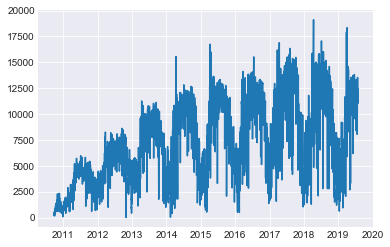

In [143]:
plt.plot(master);

In [144]:
dc_temps = pd.read_csv('dc_temps.csv')
dc_precips = pd.read_csv('dc_precips.csv')

In [145]:
rename_dict = {}
rename_dict['Unnamed: 0'] = 'Year'
dc_temps.rename(columns = rename_dict, inplace = True)
dc_precips.rename(columns = rename_dict, inplace = True)
dc_temps.set_index('Year', inplace = True)
dc_precips.set_index('Year', inplace = True)

In [146]:
dc_temps_stack = dc_temps.stack()
dc_precips_stack = dc_precips.stack()

In [147]:
master_m['avg_temp'] = np.array(dc_temps_stack)
master_m['avg_precips'] = np.array(dc_precips_stack)

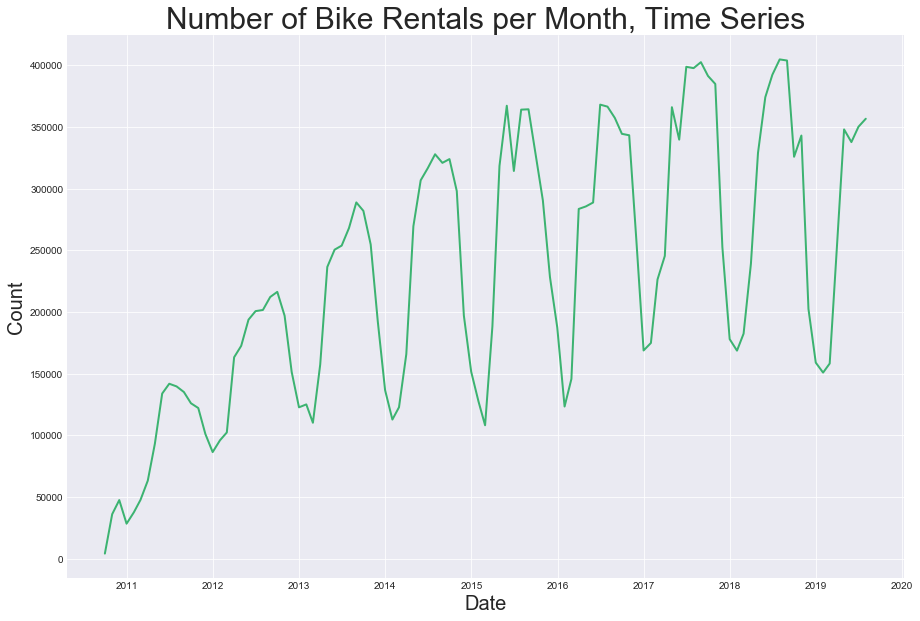

In [148]:
fig = plt.figure(figsize = (15,10))

plt.plot(master_m['count'], lw = 2, color = 'mediumseagreen')

plt.xlabel('Date', fontsize = 20);
plt.ylabel('Count', fontsize = 20);

plt.title('Number of Bike Rentals per Week, Time Series', fontsize = 30);
plt.title('Number of Bike Rentals per Month, Time Series', fontsize = 30);

In [163]:
TRAIN = .75
train_index_m = int(len(master_m)*TRAIN) + 1
train_m = master_m.iloc[:train_index_m]
test_m = master_m.iloc[train_index_m:]

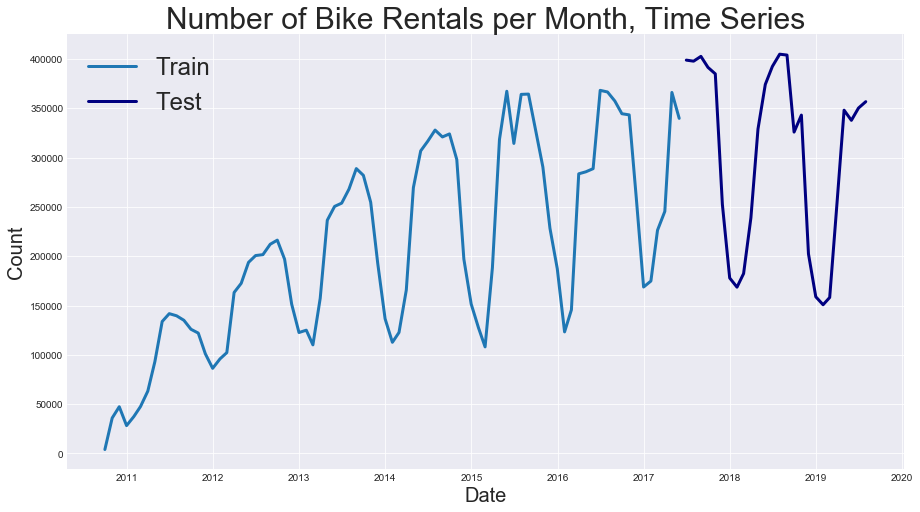

In [164]:
fig = plt.figure(figsize = (15,8))

plt.plot(train_m['count'], lw = 3)
plt.plot(test_m['count'], lw = 3, color = 'navy')
plt.legend(['Train', 'Test'],prop={'size': 24}) 

plt.xlabel('Date', fontsize = 20);
plt.ylabel('Count', fontsize = 20);

plt.title('Number of Bike Rentals per Month, Time Series', fontsize = 30);

<Figure size 432x288 with 0 Axes>

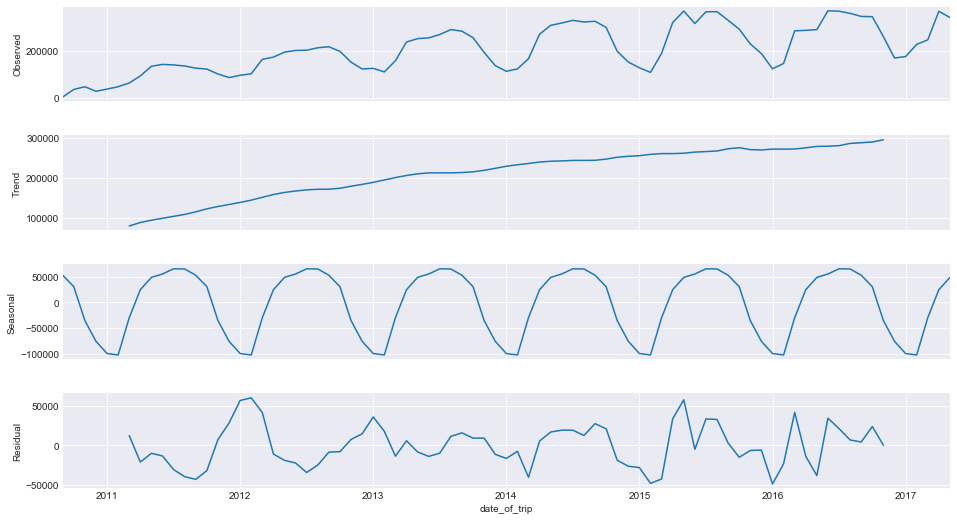

In [165]:
decomposition = seasonal_decompose(train_m['count'], freq=12)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

In [166]:
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


## First Order Difference 

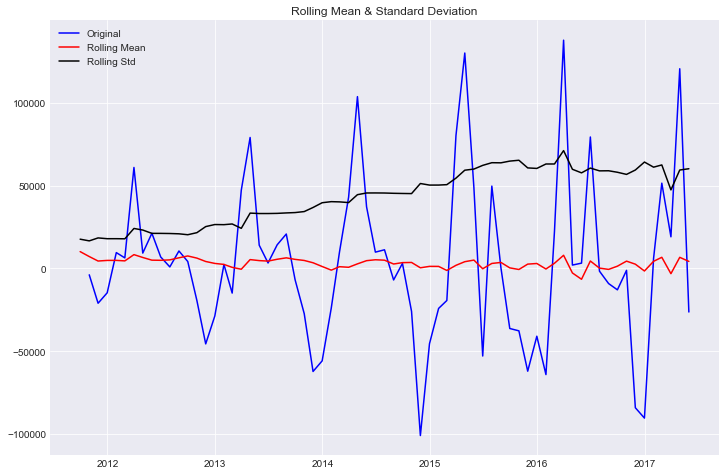

Results of Dickey-Fuller Test:
Test Statistic                 -3.316431
p-value                         0.014160
#Lags Used                     12.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64


In [167]:
train_1_diff = train_m.copy()
train_1_diff['count'] = train_m['count'].diff()
train_1_diff.dropna(inplace = True)
test_stationarity(train_1_diff['count'], 12)

## Second Order Difference

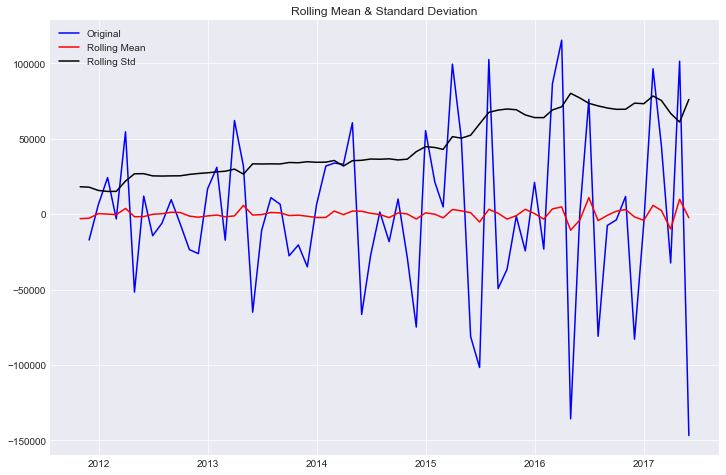

Results of Dickey-Fuller Test:
Test Statistic                -8.753455e+00
p-value                        2.796057e-14
#Lags Used                     1.100000e+01
Number of Observations Used    6.700000e+01
Critical Value (1%)           -3.531955e+00
Critical Value (5%)           -2.905755e+00
Critical Value (10%)          -2.590357e+00
dtype: float64


In [168]:
train_2_diff = train_m.copy()
train_2_diff['count'] = train_m['count'].diff().diff()
train_2_diff.dropna(inplace = True)
test_stationarity(train_2_diff['count'], 12)

## First Seasonal Difference

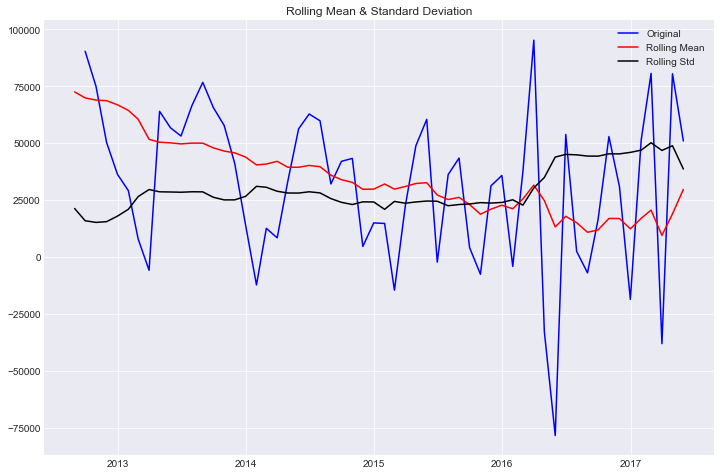

Results of Dickey-Fuller Test:
Test Statistic                 -1.953684
p-value                         0.307243
#Lags Used                      9.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


In [169]:
train_1_season = train_m.copy()
train_1_season = train_1_season - train_1_season.shift(12)
train_1_season.dropna(inplace = True)
test_stationarity(train_1_season['count'], 12)

## First Seasonal Difference of First Order Difference

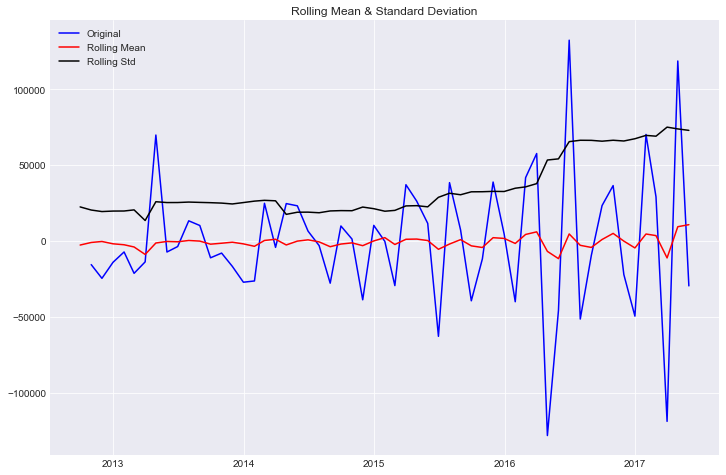

Results of Dickey-Fuller Test:
Test Statistic                -6.093700e+00
p-value                        1.021998e-07
#Lags Used                     8.000000e+00
Number of Observations Used    5.900000e+01
Critical Value (1%)           -3.546395e+00
Critical Value (5%)           -2.911939e+00
Critical Value (10%)          -2.593652e+00
dtype: float64


In [170]:
train_1_season_diff_1_diff = train_1_diff.copy()
train_1_season_diff_1_diff['count'] = train_1_season_diff_1_diff['count'] - train_1_season_diff_1_diff['count'].shift(12)
train_1_season_diff_1_diff.dropna(inplace = True)
test_stationarity(train_1_season_diff_1_diff['count'], 12)

## This suggests, d = 1, D = 1. Now look at ACF and PACF.

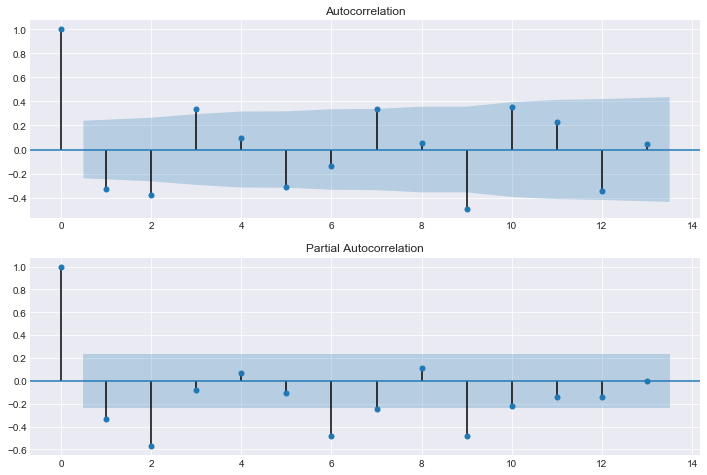

In [171]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(train_1_season_diff_1_diff['count'].iloc[1:], lags=13, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(train_1_season_diff_1_diff['count'].iloc[1:], lags=13, ax=ax2)

# AFC looks good. PAFC suggests 2 significant lags (p = 2). AFC suggests q = 1- 3.

## Models to try:

#### (2,1,0)(0,1,0,12)
#### (2,1,0)(0,1,1,12)
#### (2,1,0)(1,1,0,12)
#### (2,1,1)(0,1,0,12)
#### (2,1,1)(0,1,1,12)
#### (2,1,1)(1,1,0,12)
#### (2,1,2)(0,1,0,12)
#### (2,1,2)(0,1,1,12)
#### (2,1,2)(1,1,0,12)
#### (2,1,3)(0,1,0,12)
#### (2,1,3)(0,1,1,12)
#### (2,1,3)(1,1,0,12)

In [172]:
orders = [(2,1,0),(2,1,1),(2,1,2),(2,1,3)]
seasonal_orders = [(0,1,0,12),(1,1,0,12),(0,1,1,12)]

                                 Statespace Model Results                                 
Dep. Variable:                              count   No. Observations:                   81
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -803.368
Date:                            Tue, 10 Sep 2019   AIC                           1612.736
Time:                                    11:21:09   BIC                           1619.394
Sample:                                09-30-2010   HQIC                          1615.374
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4843      0.066     -7.297      0.000      -0.614      -0.354
ar.L2         -0.5856      0.086   

                                 Statespace Model Results                                 
Dep. Variable:                              count   No. Observations:                   81
Model:             SARIMAX(2, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -802.543
Date:                            Tue, 10 Sep 2019   AIC                           1615.087
Time:                                    11:21:10   BIC                           1626.184
Sample:                                09-30-2010   HQIC                          1619.484
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5969      0.248     -2.410      0.016      -1.082      -0.111
ar.L2         -0.5633      0.129   

                                 Statespace Model Results                                 
Dep. Variable:                              count   No. Observations:                   81
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 12)   Log Likelihood                -802.044
Date:                            Tue, 10 Sep 2019   AIC                           1616.088
Time:                                    11:21:13   BIC                           1629.405
Sample:                                09-30-2010   HQIC                          1621.364
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5021      0.028    -17.645      0.000      -0.558      -0.446
ar.L2         -1.0000      0.041   

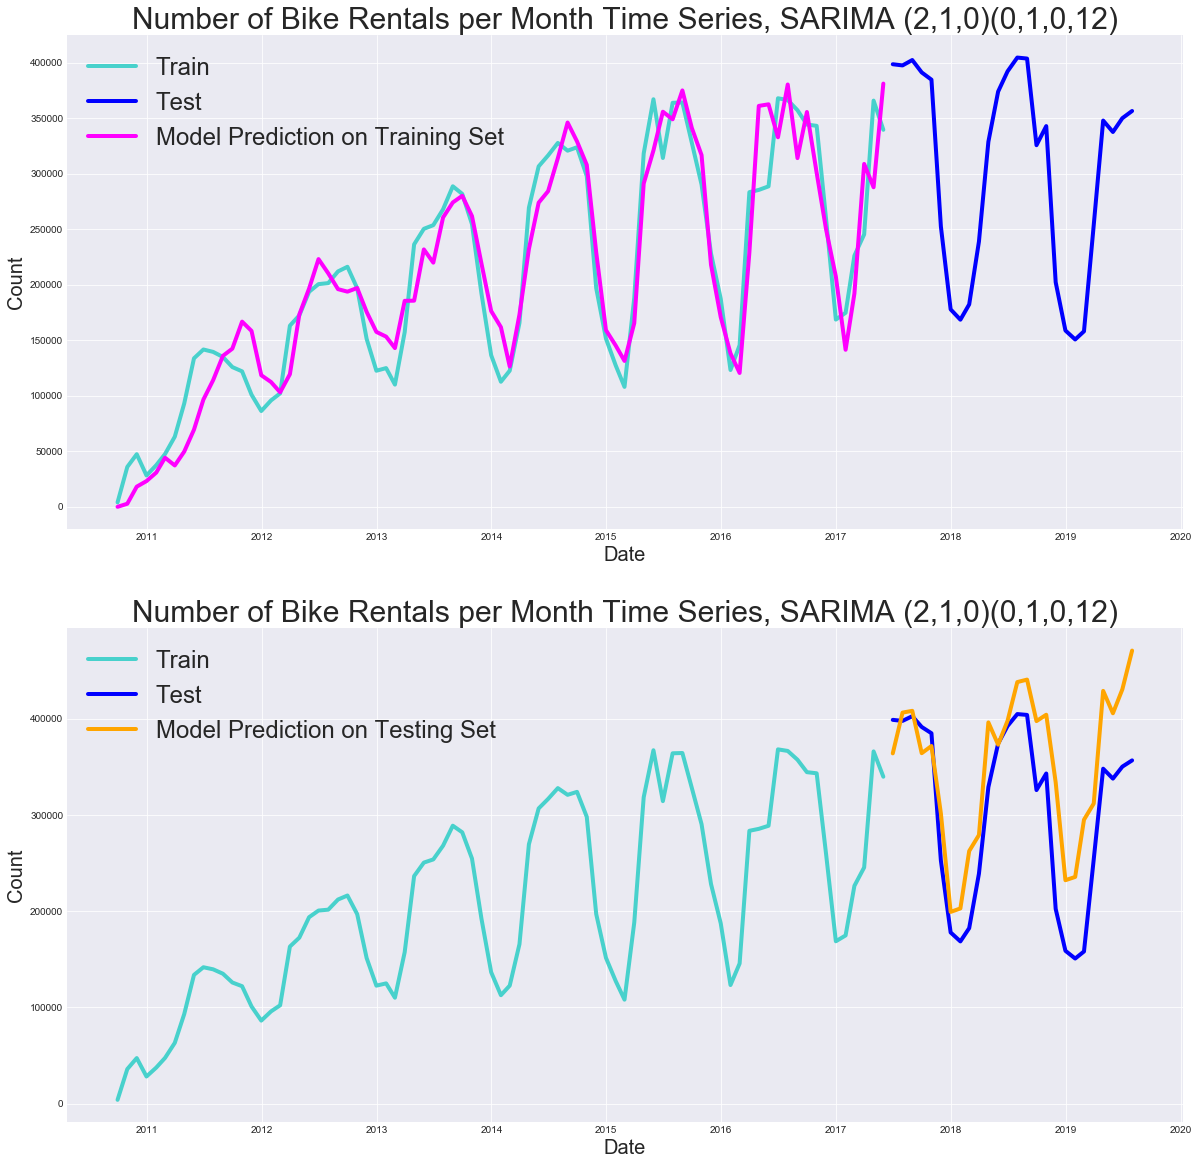

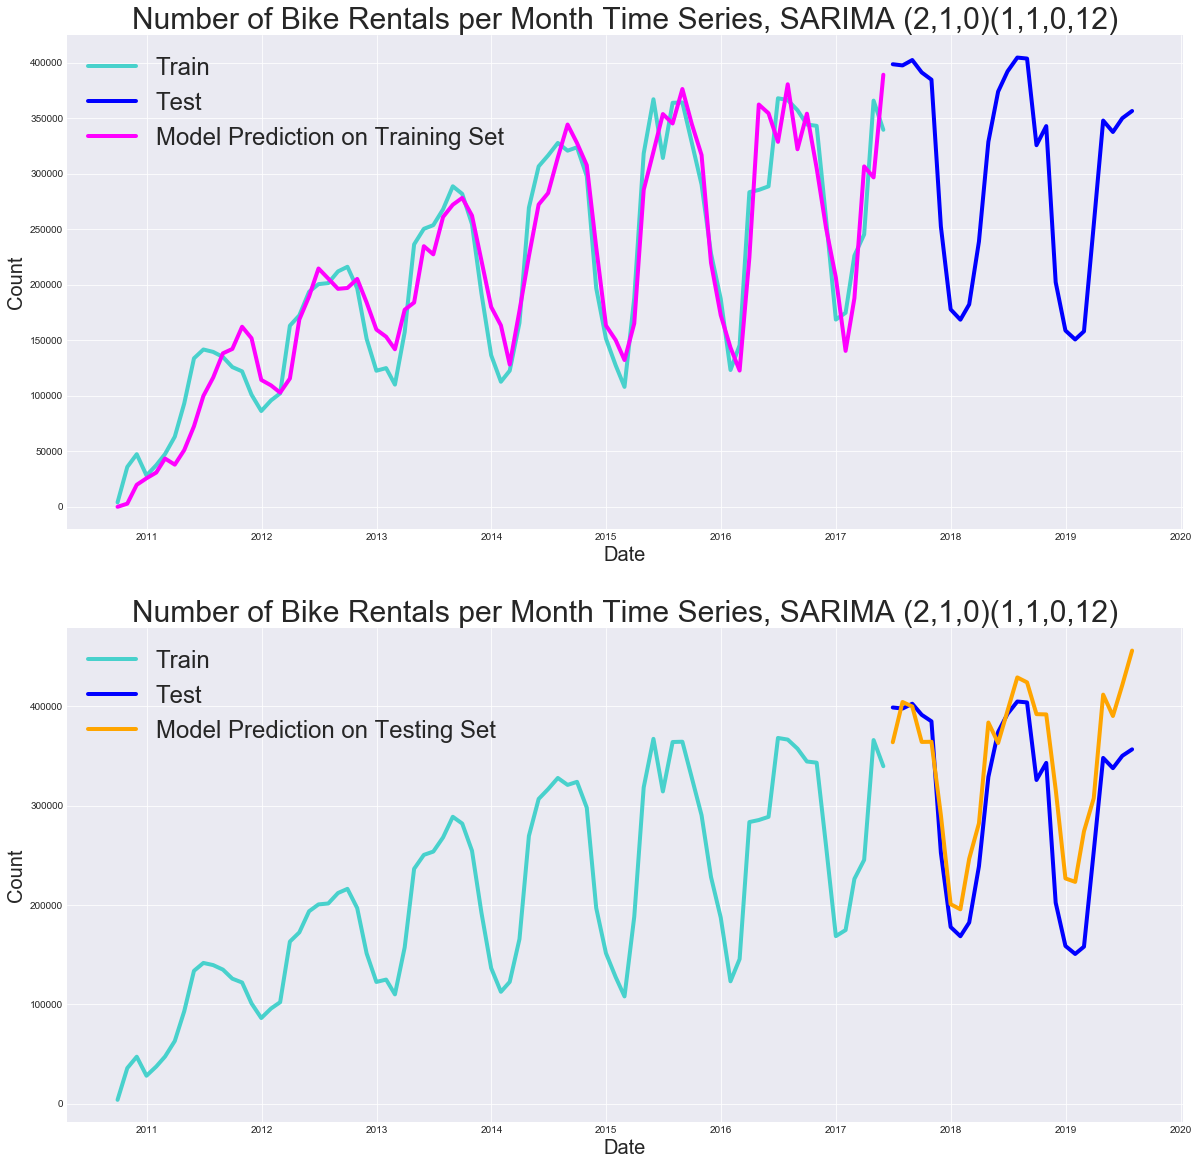

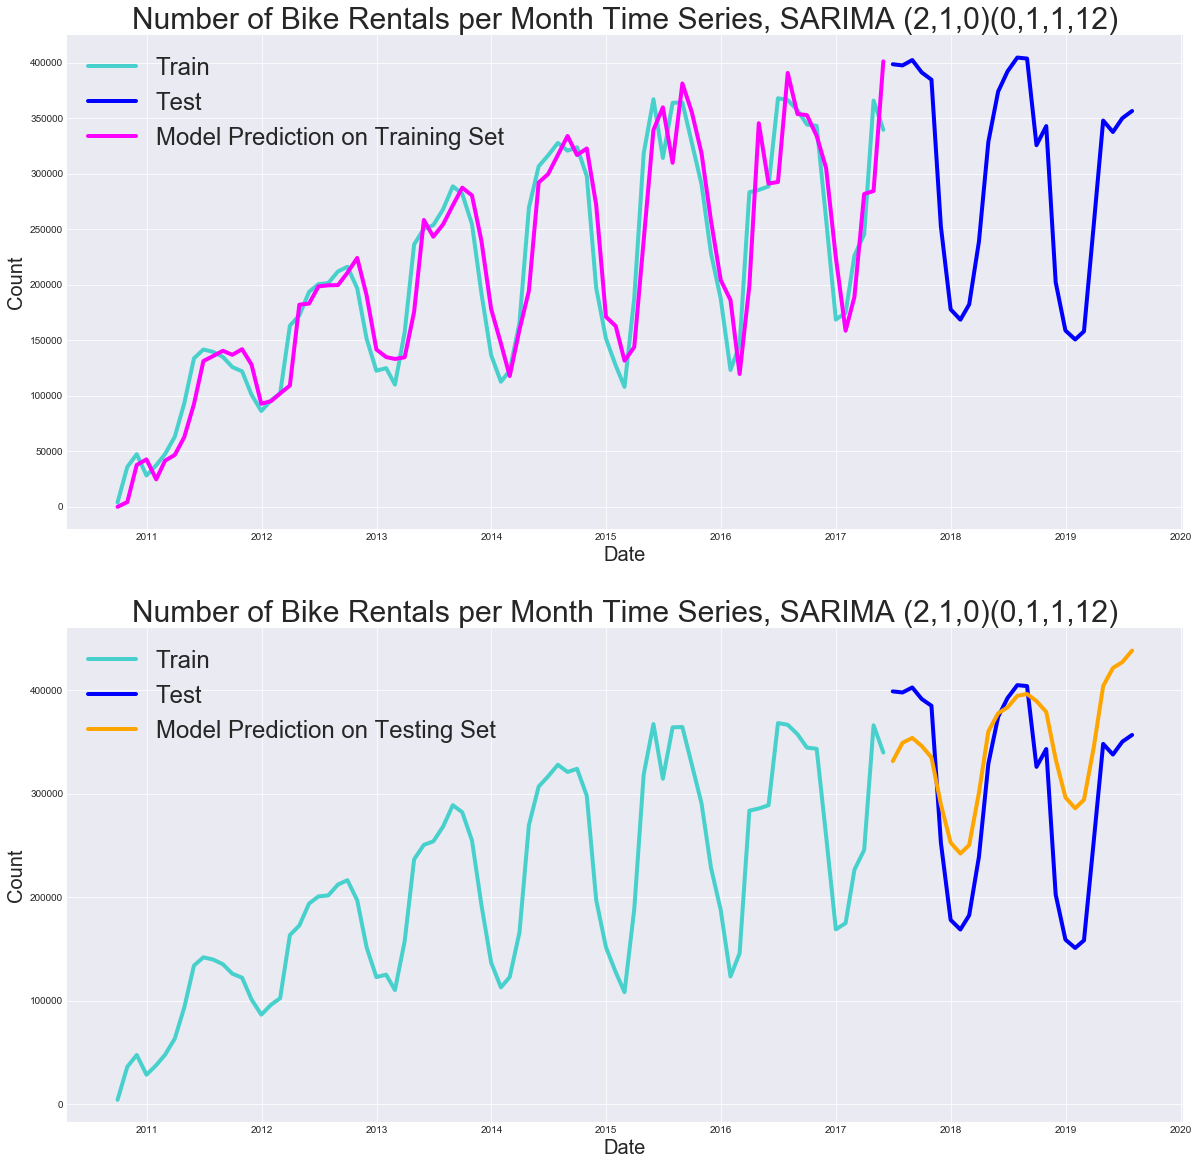

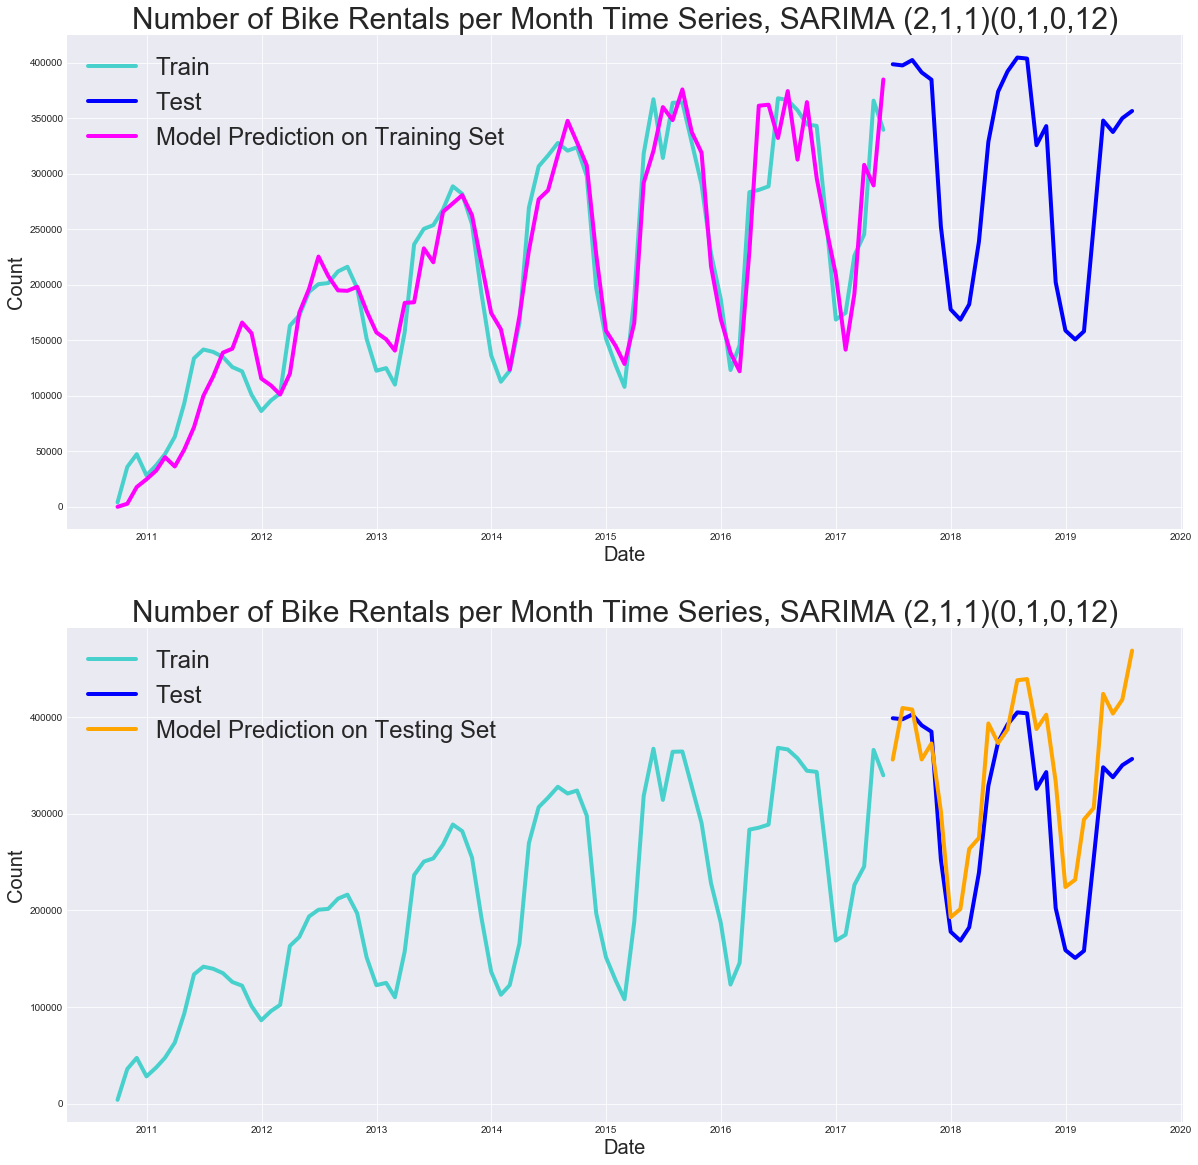

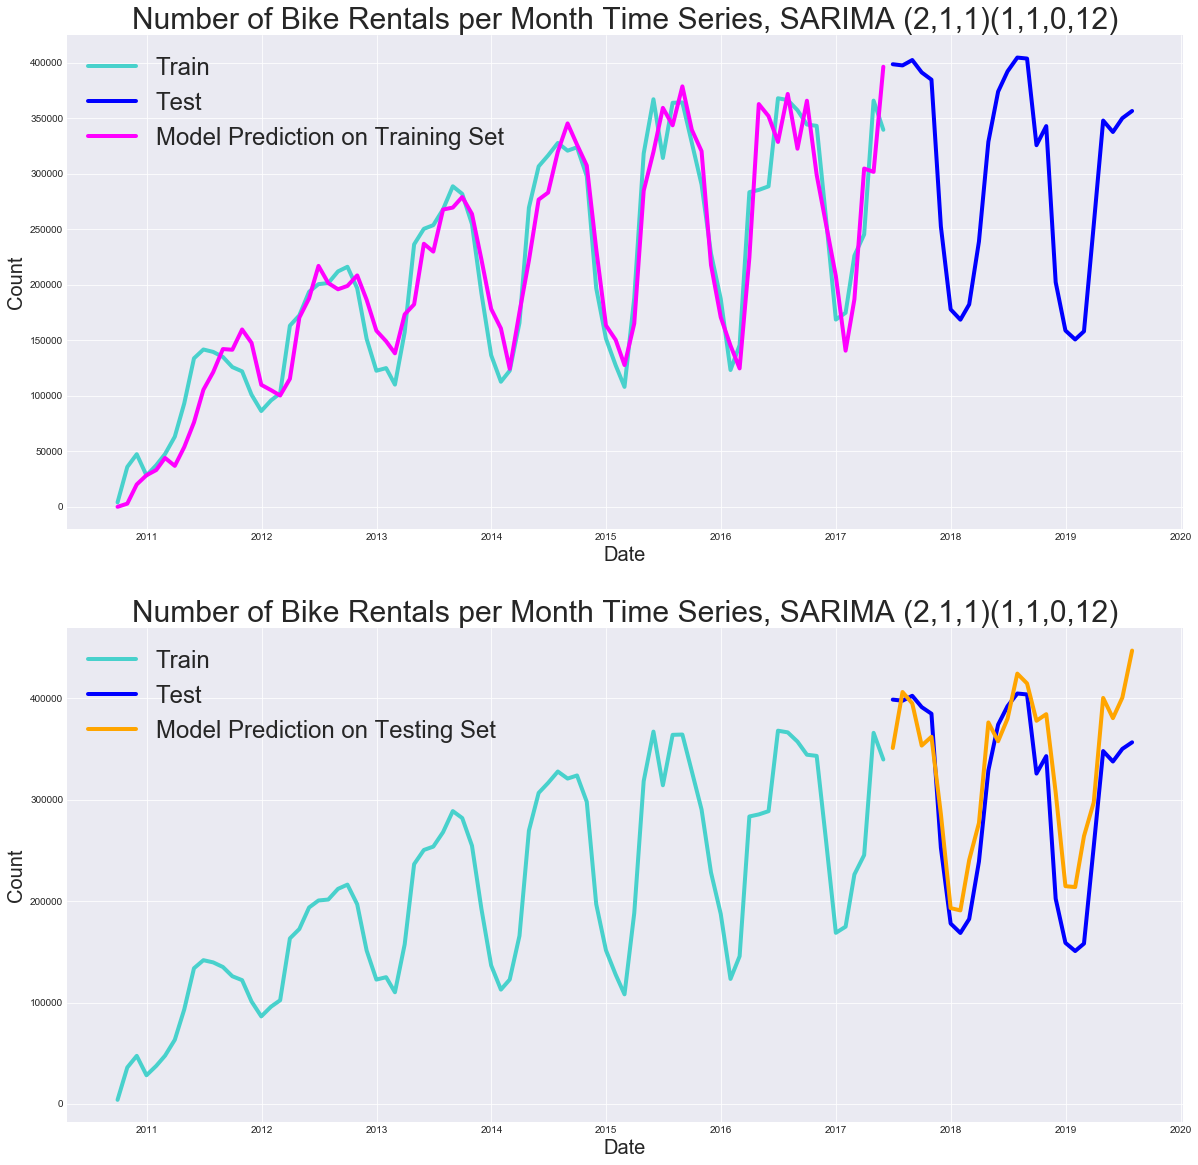

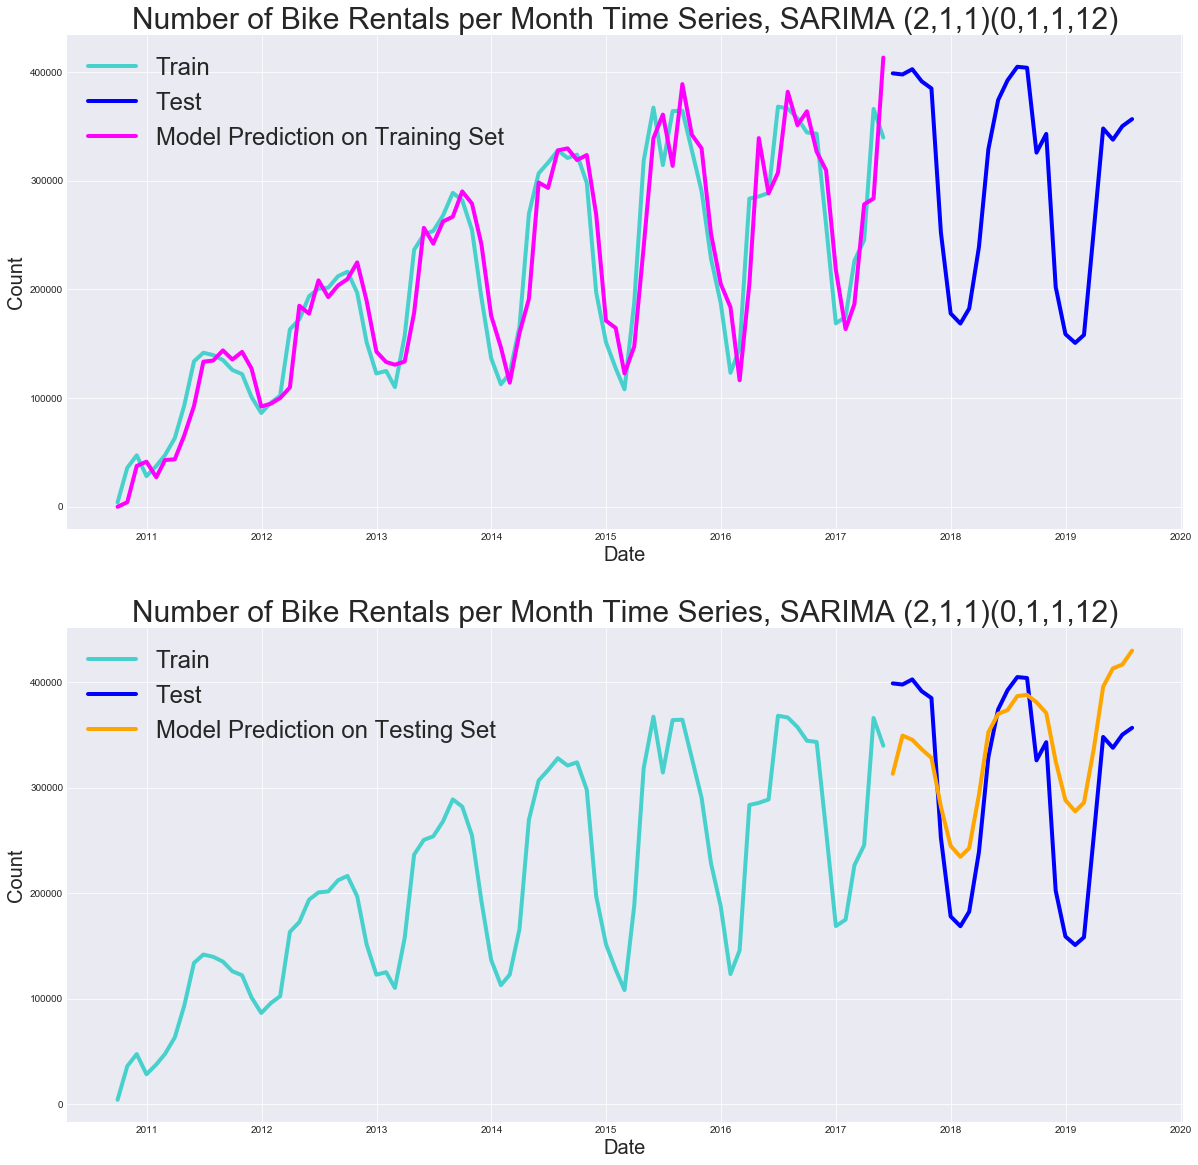

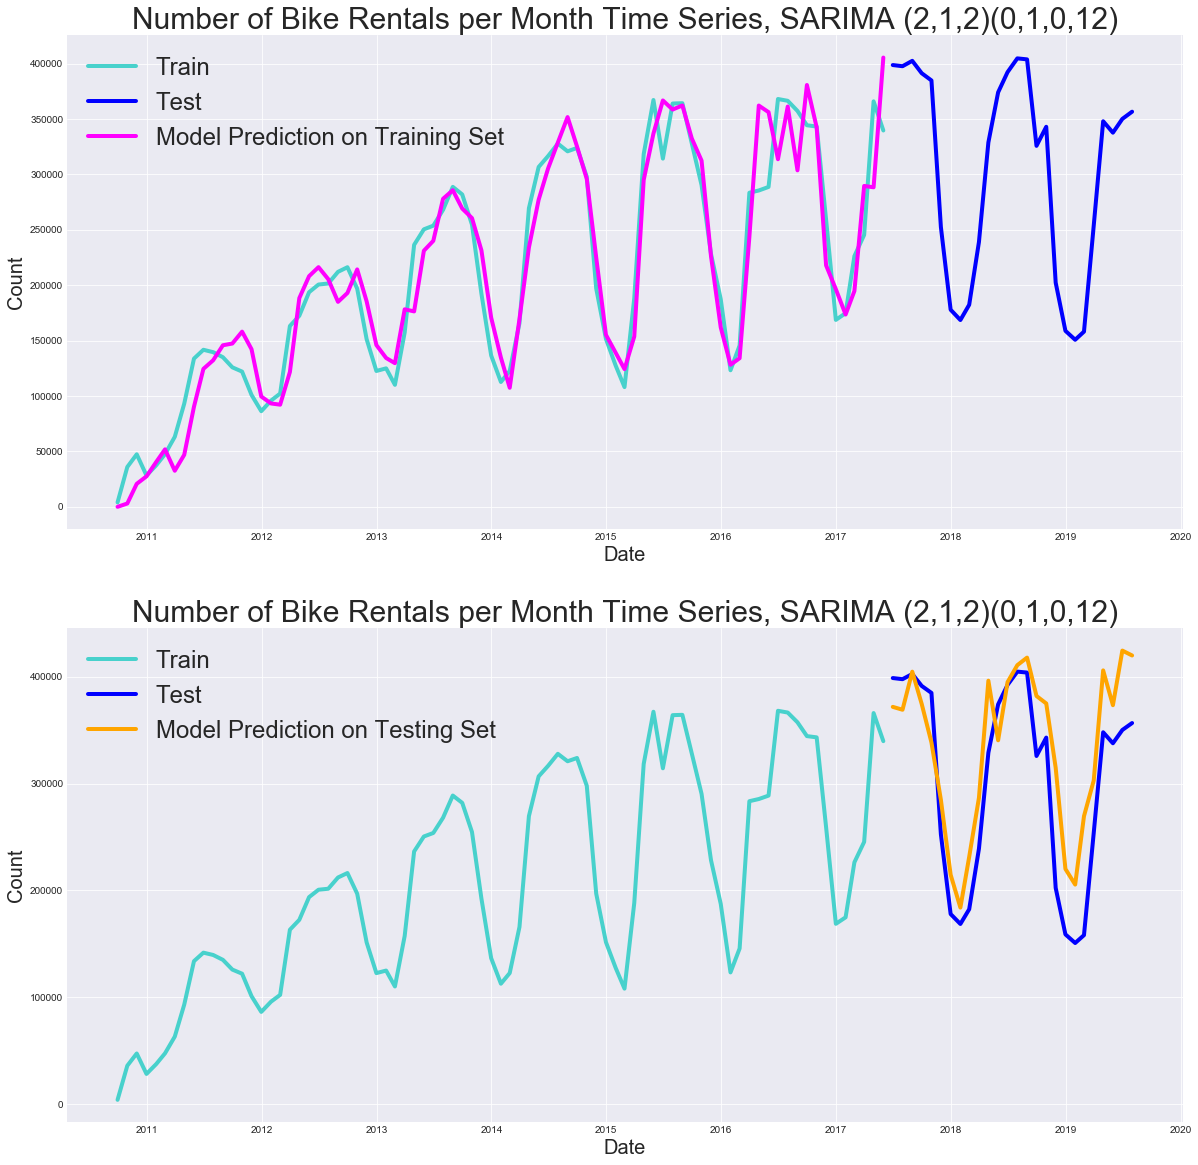

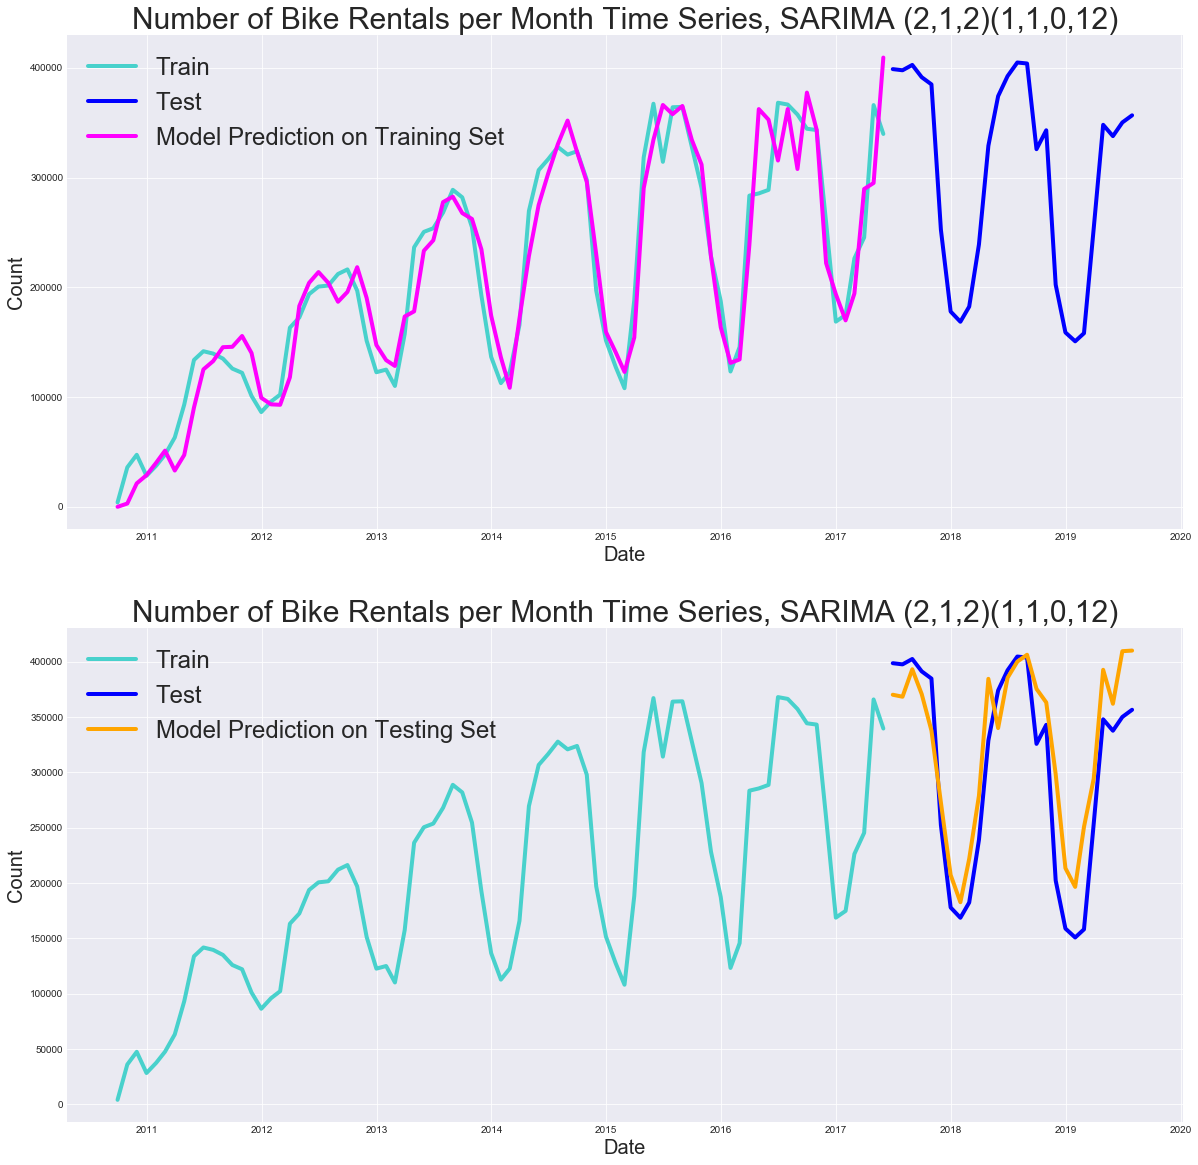

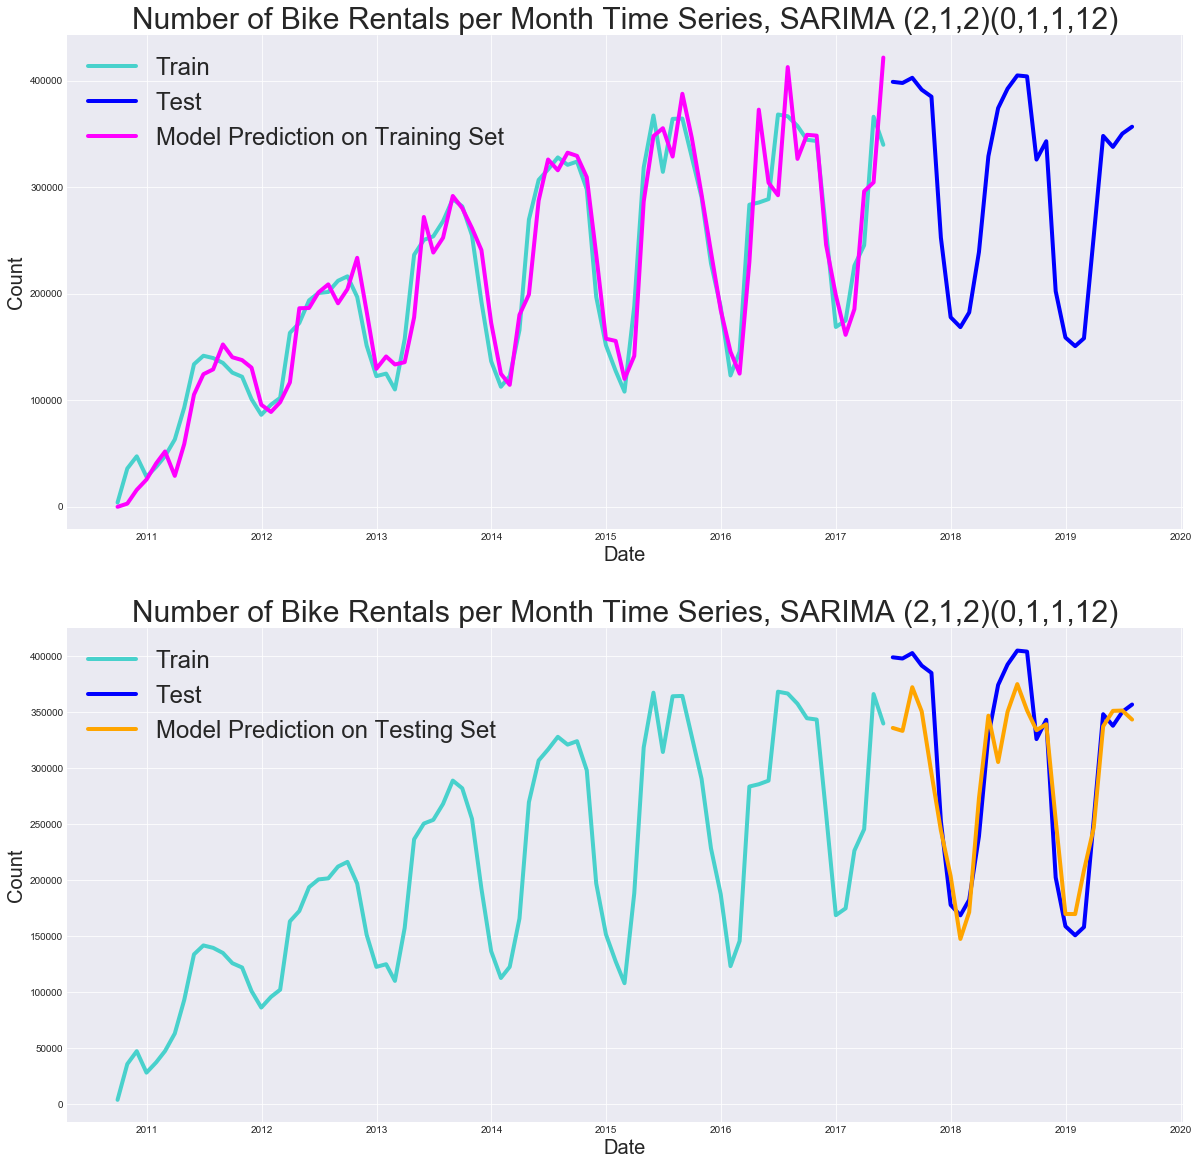

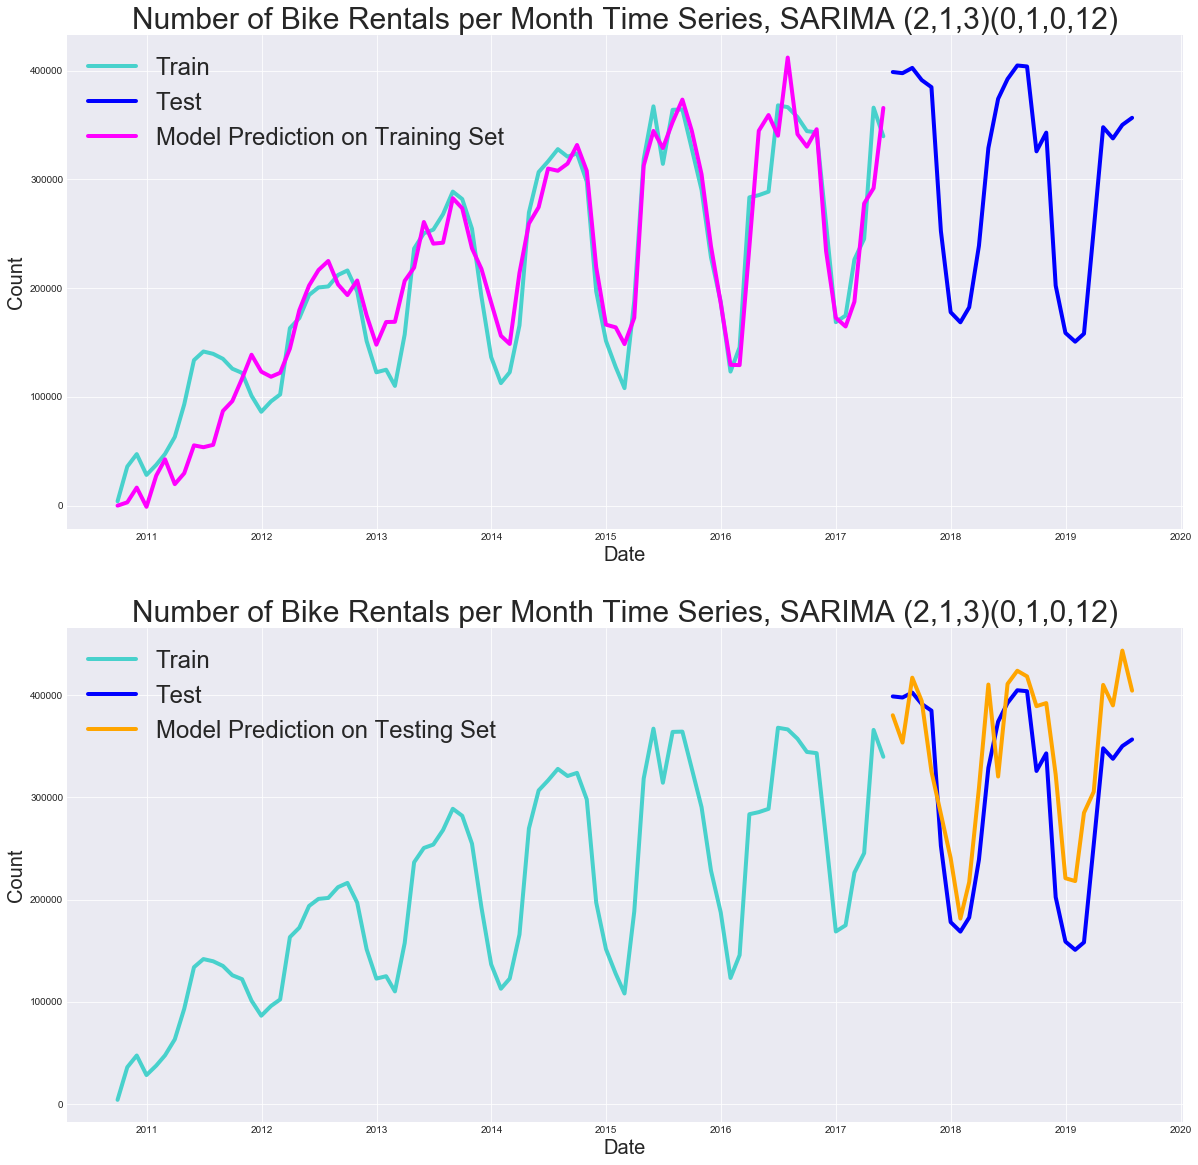

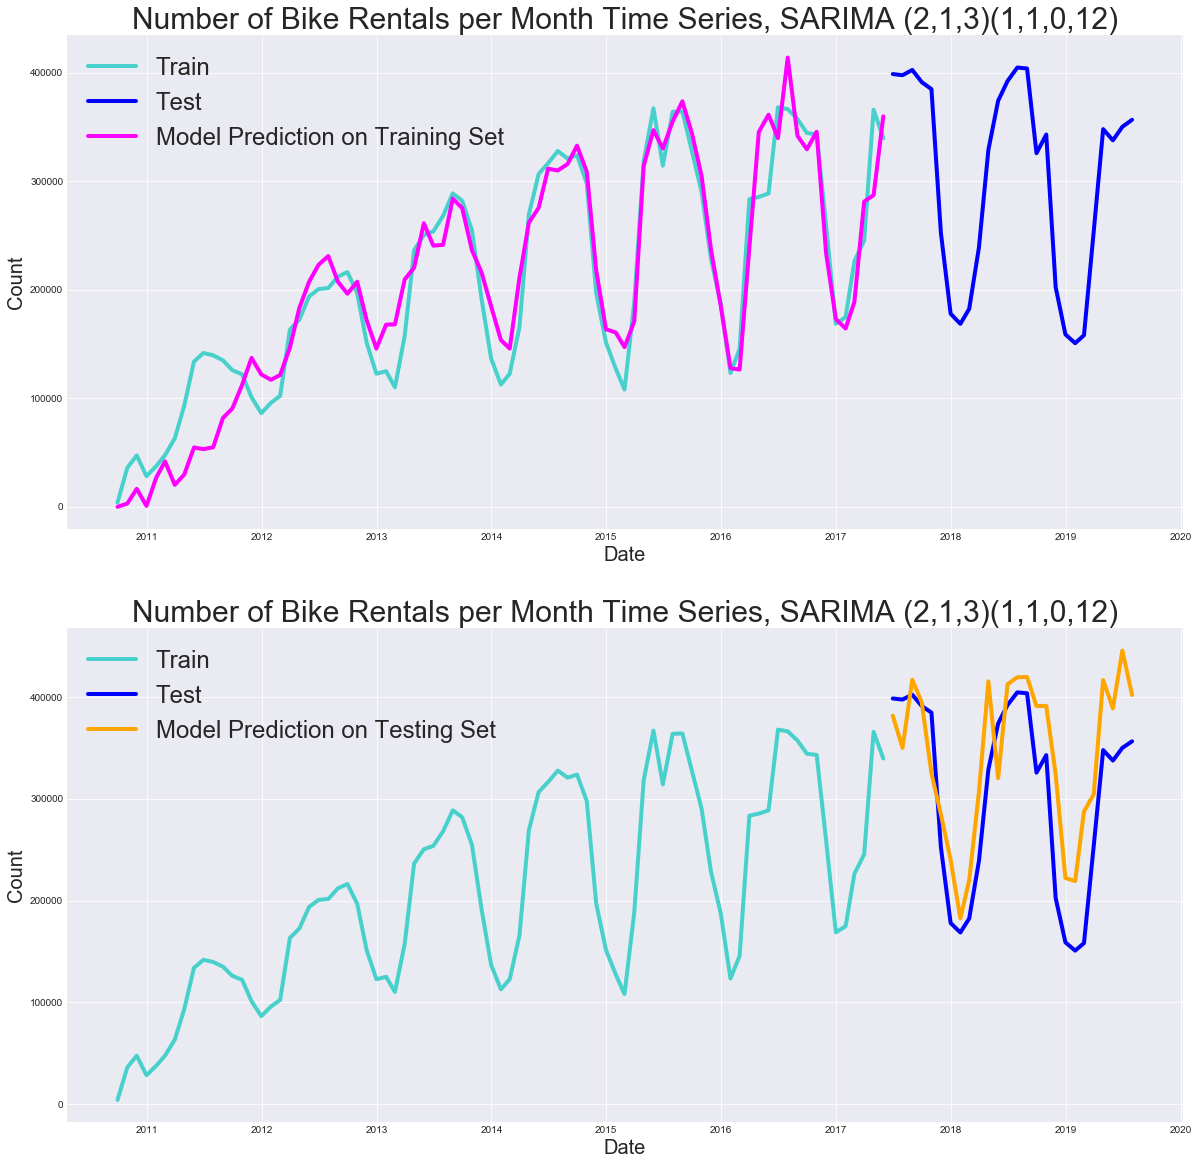

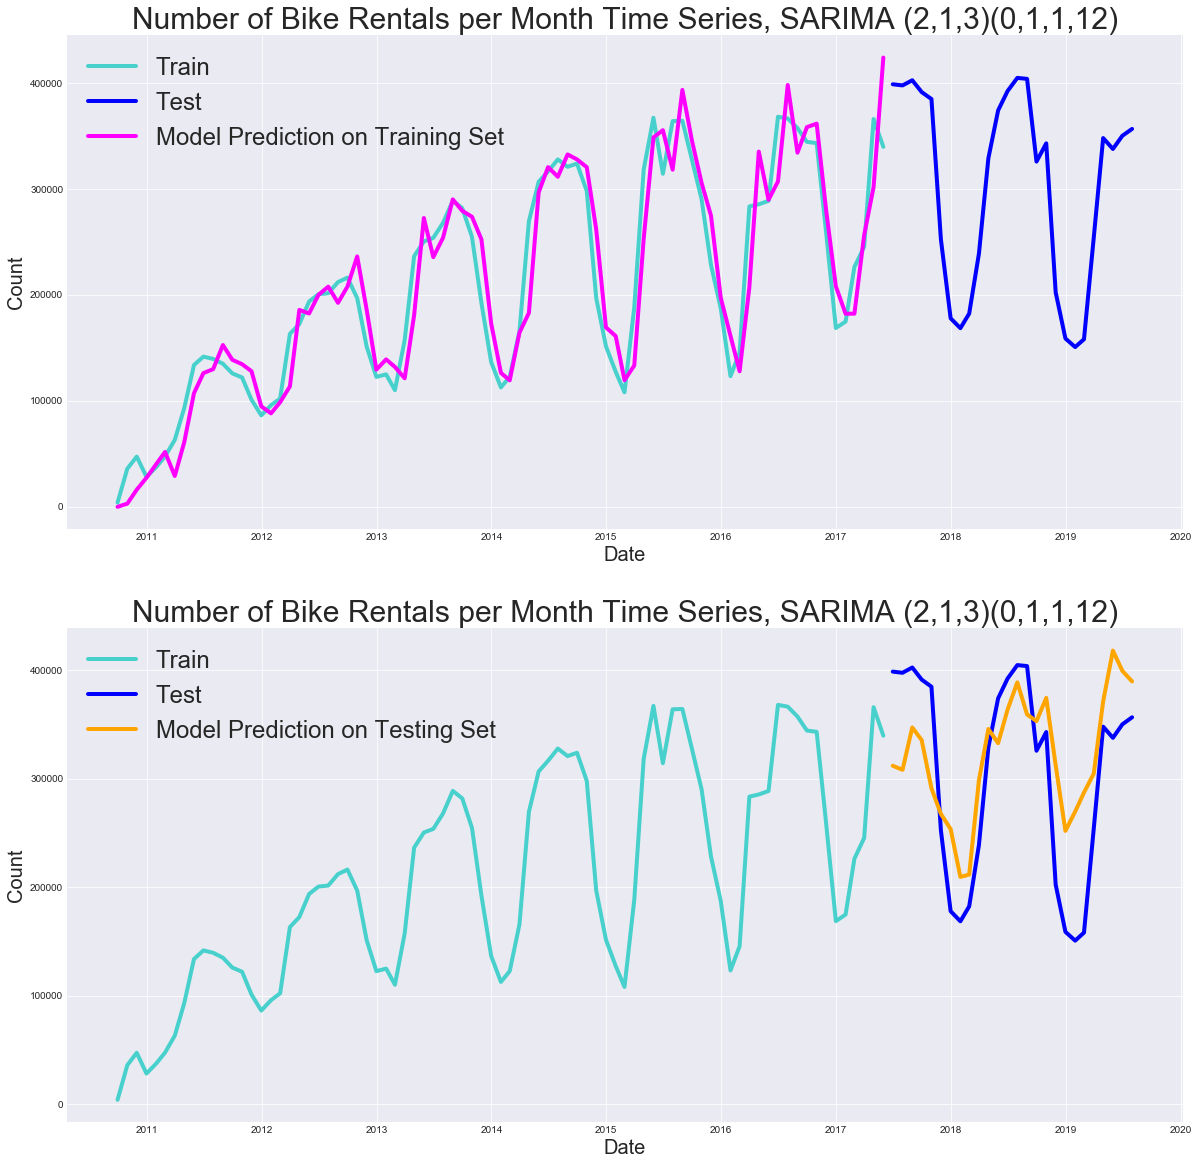

In [321]:
mse_dict = {}

for o in orders:   
    for s_o in seasonal_orders:
        model = sm.tsa.statespace.SARIMAX(train_m['count'], order=(o[0],o[1],o[2]), 
                                          seasonal_order=(s_o[0],s_o[1],s_o[2],s_o[3])).fit()
        print(model.summary())
        train_mse, test_mse = mse.compare_mse(model, train_m, test_m)
        pplot.prediction_plot(model, train_m, test_m, o[0],o[1],o[2],s_o[0],s_o[1],s_o[2],s_o[3])
        
        mse_dict[f'{o},{s_o}'] = {'Training MSE': "{:.2e}".format(train_mse), 'Testing MSE': "{:.2e}".format(test_mse)}
        

In [322]:
mse_dict

{'(2, 1, 0),(0, 1, 0, 12)': {'Training MSE': '1.04e+09',
  'Testing MSE': '4.33e+09'},
 '(2, 1, 0),(1, 1, 0, 12)': {'Training MSE': '1.02e+09',
  'Testing MSE': '3.19e+09'},
 '(2, 1, 0),(0, 1, 1, 12)': {'Training MSE': '1.18e+09',
  'Testing MSE': '5.57e+09'},
 '(2, 1, 1),(0, 1, 0, 12)': {'Training MSE': '1.03e+09',
  'Testing MSE': '4.05e+09'},
 '(2, 1, 1),(1, 1, 0, 12)': {'Training MSE': '9.92e+08',
  'Testing MSE': '2.51e+09'},
 '(2, 1, 1),(0, 1, 1, 12)': {'Training MSE': '1.14e+09',
  'Testing MSE': '4.98e+09'},
 '(2, 1, 2),(0, 1, 0, 12)': {'Training MSE': '8.85e+08',
  'Testing MSE': '2.68e+09'},
 '(2, 1, 2),(1, 1, 0, 12)': {'Training MSE': '8.76e+08',
  'Testing MSE': '1.91e+09'},
 '(2, 1, 2),(0, 1, 1, 12)': {'Training MSE': '9.27e+08',
  'Testing MSE': '1.46e+09'},
 '(2, 1, 3),(0, 1, 0, 12)': {'Training MSE': '1.09e+09',
  'Testing MSE': '3.58e+09'},
 '(2, 1, 3),(1, 1, 0, 12)': {'Training MSE': '1.10e+09',
  'Testing MSE': '3.72e+09'},
 '(2, 1, 3),(0, 1, 1, 12)': {'Training MSE'

## Best two are (2,1,2)(0,1,1,12), and (2,1,2)(1,1,0,12).

In [181]:
model_212_01112 = sm.tsa.statespace.SARIMAX(train_m['count'], trend='n', order=(2,1,2), 
                                          seasonal_order=(0,1,1,12)).fit()
model_212_11012 = sm.tsa.statespace.SARIMAX(train_m['count'], trend='n', order=(2,1,2), 
                                          seasonal_order=(1,1,0,12)).fit()

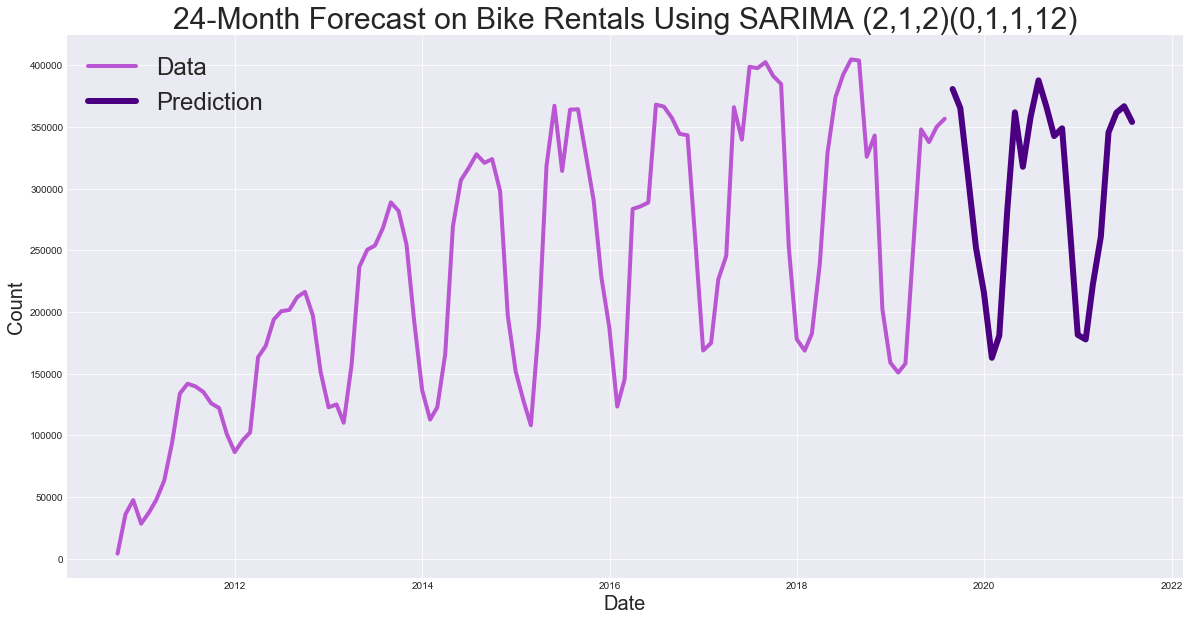

In [315]:
pplot.forecast_plot(model_212_01112,master_m,24,2,1,2,0,1,1,12)

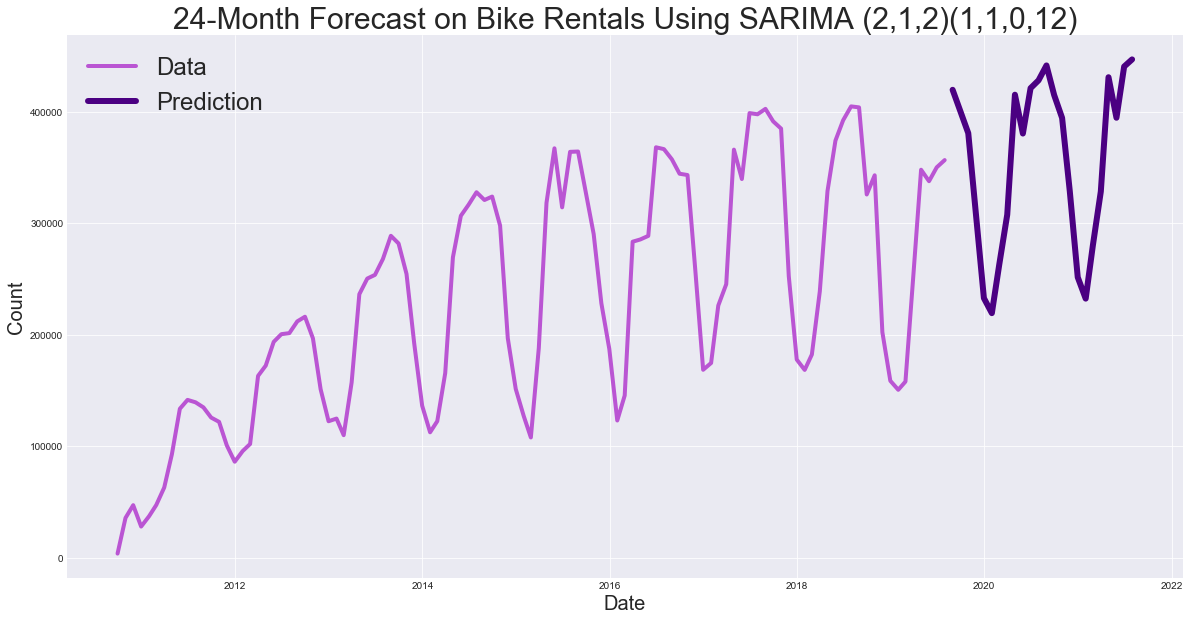

In [316]:
pplot.forecast_plot(model_212_11012,master_m,24,2,1,2,1,1,0,12)

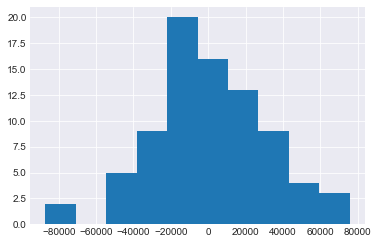

In [240]:
model_212_01112.resid.hist()

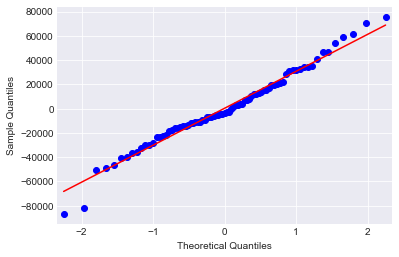

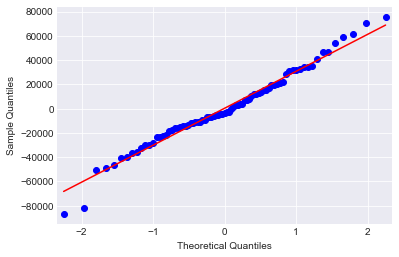

In [246]:
qqplot(model_212_01112.resid, line = 's' )

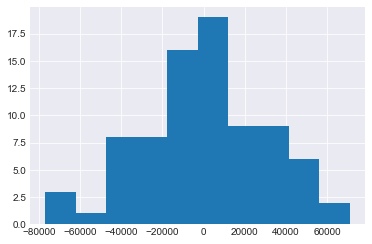

In [242]:
model_212_11012.resid.hist()

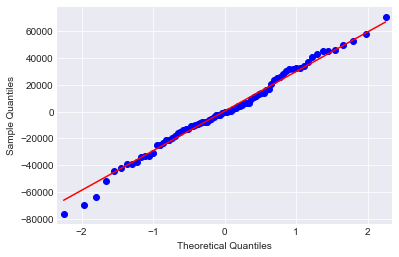

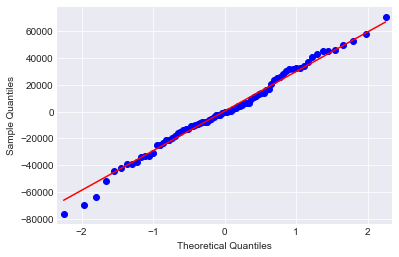

In [247]:
qqplot(model_212_11012.resid, line = 's' )

## Residuals look normal for both models.

## Will start with SARIMA (2,1,2) (0,1,1,12) and SARIMA (2,1,2)(1,1,0,12) going forward. Next, look at monthly average weather and precipitation as regressors.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2bbd46d8>,
      dtype=object)

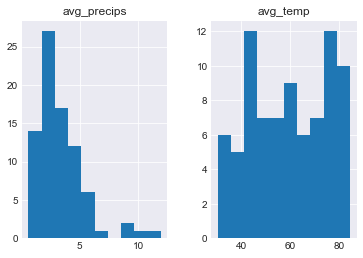

In [194]:
train_m[['avg_temp','avg_precips']].hist()

In [248]:
scale = MinMaxScaler()
scale.fit(train_m[['avg_temp','avg_precips']])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [249]:
train_m_scaled = train_m.copy()
test_m_scaled = test_m.copy()

In [250]:
train_m_scaled[['avg_temp','avg_precips']] = scale.transform(train_m_scaled[['avg_temp','avg_precips']])
test_m_scaled[['avg_temp','avg_precips']] = scale.transform(test_m_scaled[['avg_temp','avg_precips']])

In [251]:
train_m_scaled[['avg_temp','avg_precips']].corr()

avg_temp  avg_precips
avg_temp     1.000000     0.253001
avg_precips  0.253001     1.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c210d19b0>,
      dtype=object)

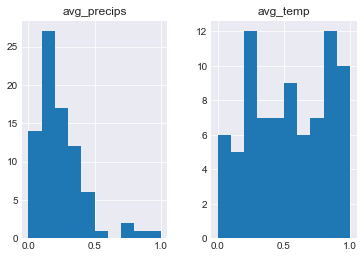

In [252]:
train_m_scaled[['avg_temp','avg_precips']].hist()

In [292]:
exog_train = np.array([train_m_scaled['avg_temp'], train_m_scaled['avg_precips']]).T
exog_test = np.array([test_m_scaled['avg_temp'], test_m_scaled['avg_precips']]).T

In [296]:
model_with_weather_212_01112 = sm.tsa.statespace.SARIMAX(train_m['count'], trend='n', order=(2,1,2), exog = exog_train,
                                          seasonal_order=(0,1,1,12)).fit()

In [298]:
model_with_weather_212_01112.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              count   No. Observations:                   81
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 12)   Log Likelihood                -764.382
Date:                            Tue, 10 Sep 2019   AIC                           1544.765
Time:                                    10:43:34   BIC                           1562.521
Sample:                                09-30-2010   HQIC                          1551.800
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2.532e+05   2.33e+04     10.874      0.000    2.08e+05    2.99e+05
x2         -5.708e+04   9263.225     -6.162      0.000   -7.52e+04   -3.89e+04
ar.L1         -0.4866      0.177     -2.754      0.006      -0.833      -0.140
ar.L2          0.2749      0.143      1.918      0.055      -0.006       0.556
ma.L1          0.2389      0.174      1.376      0.169      -0.101       0.579
ma.L2         -0.7379      0.137     -5.405      0.000      -1.006      -0.470
ma.S.L12      -0.0020      0.080     -0.025      0.980      -0.158       0.154
sigma2      3.646e+08      0.505   7.23e+08      0.000    3.65e+08    3.65e+08
===================================================================================
Ljung-Box (Q):                       38.91   Jarque-Bera (JB):                 0.49
Prob(Q):                              0.52   Prob(JB):                         0.78
Heteroskedasticity (H):               1.25   Skew:                            -0.13
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.26e+25. Standard errors may be unstable.
"""

In [300]:
mse.compare_mse_exog(model_with_weather_212_01112, train_m_scaled, test_m_scaled)

Training MSE:  1.38e+09
Testing MSE:  2.42e+09


(1384356587.6073058, 2420457762.160835)

In [302]:
mse.compare_mse(model_212_01112, train_m, test_m)

Training MSE:  9.27e+08
Testing MSE:  1.46e+09


(927192259.9132563, 1459379097.9912221)

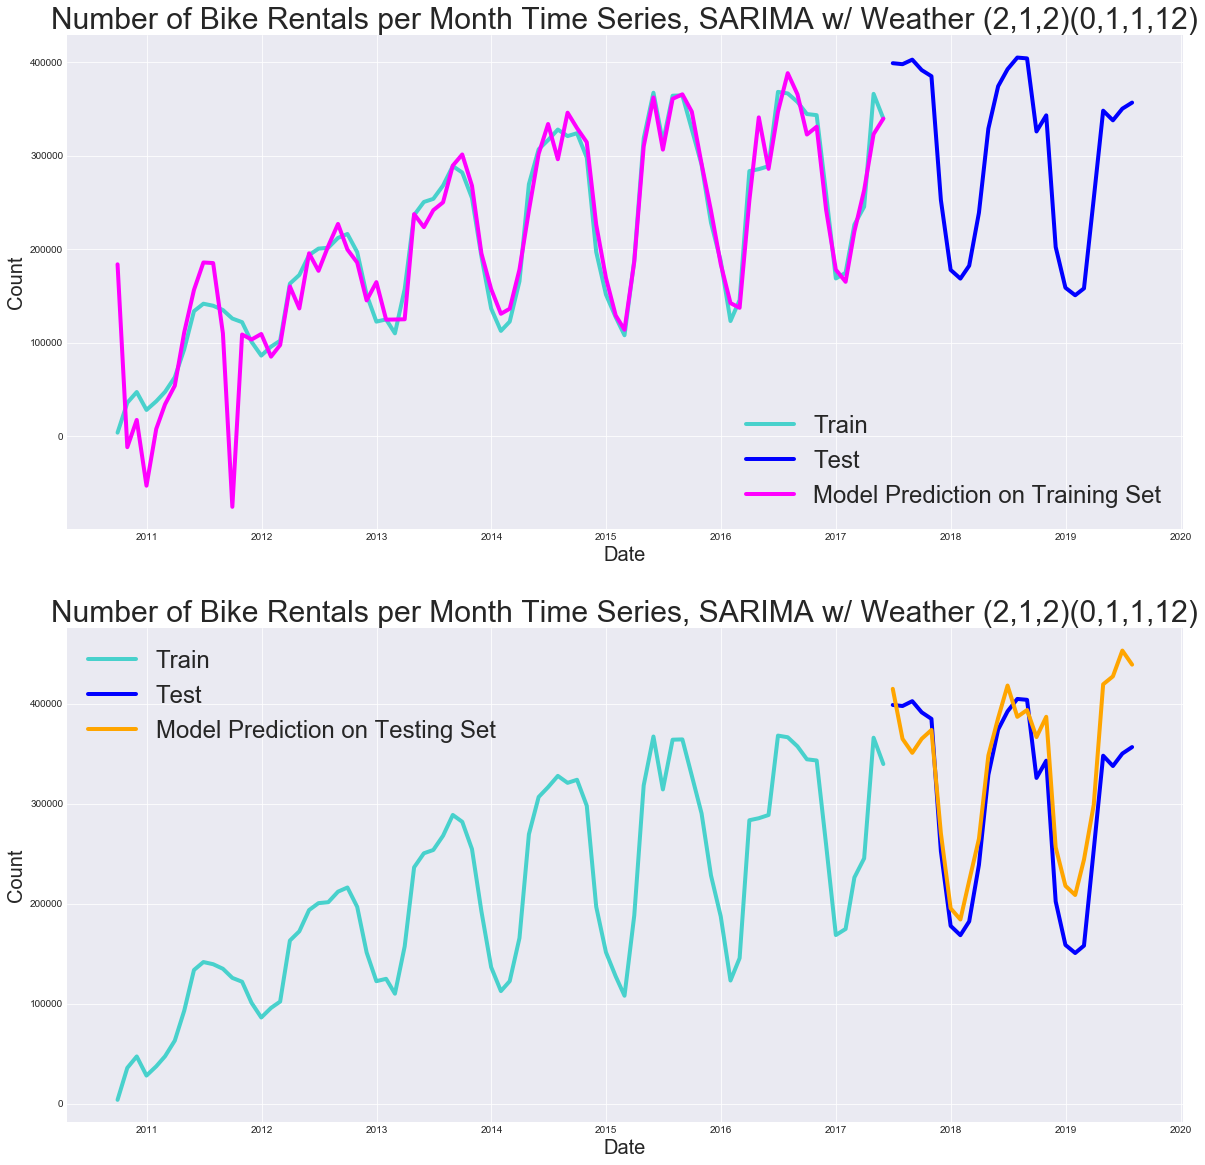

In [314]:
pplot.prediction_plot_exog(model_with_weather_212_01112 , train_m_scaled, test_m_scaled, 2,1,2,0,1,1,12)

In [303]:
model_with_weather_212_11012 = sm.tsa.statespace.SARIMAX(train_m['count'], trend='n', order=(2,1,2), exog = exog_train,
                                          seasonal_order=(1,1,0,12)).fit()

In [304]:
model_with_weather_212_11012.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              count   No. Observations:                   81
Model:             SARIMAX(2, 1, 2)x(1, 1, 0, 12)   Log Likelihood                -764.383
Date:                            Tue, 10 Sep 2019   AIC                           1544.765
Time:                                    10:59:27   BIC                           1562.521
Sample:                                09-30-2010   HQIC                          1551.801
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2.532e+05   2.33e+04     10.880      0.000    2.08e+05    2.99e+05
x2         -5.708e+04   9260.502     -6.164      0.000   -7.52e+04   -3.89e+04
ar.L1         -0.4868      0.177     -2.758      0.006      -0.833      -0.141
ar.L2          0.2747      0.143      1.918      0.055      -0.006       0.555
ma.L1          0.2390      0.174      1.374      0.169      -0.102       0.580
ma.L2         -0.7381      0.137     -5.403      0.000      -1.006      -0.470
ar.S.L12      -0.0012      0.080     -0.015      0.988      -0.158       0.155
sigma2      3.646e+08      0.508   7.18e+08      0.000    3.65e+08    3.65e+08
===================================================================================
Ljung-Box (Q):                       38.94   Jarque-Bera (JB):                 0.49
Prob(Q):                              0.52   Prob(JB):                         0.78
Heteroskedasticity (H):               1.25   Skew:                            -0.13
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.49e+24. Standard errors may be unstable.
"""

In [305]:
mse.compare_mse_exog(model_with_weather_212_11012, train_m_scaled, test_m_scaled)

Training MSE:  1.39e+09
Testing MSE:  2.42e+09


(1385022153.0103037, 2423311777.564947)

In [308]:
mse.compare_mse(model_212_11012, train_m, test_m)

Training MSE:  8.76e+08
Testing MSE:  1.91e+09


(876443300.382147, 1913787806.0143754)

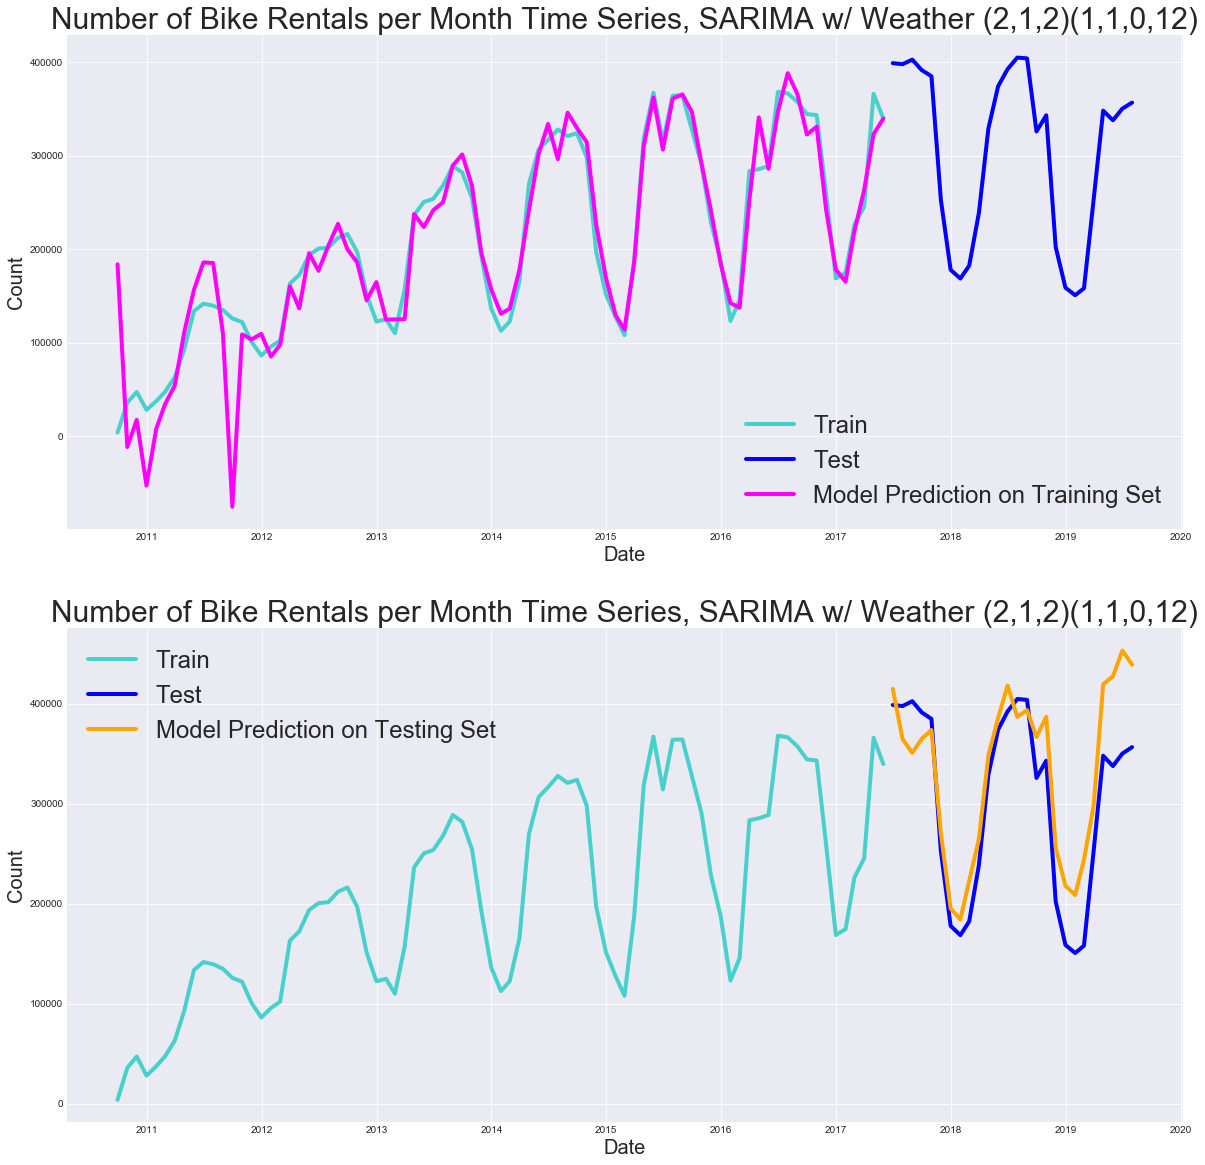

In [318]:
pplot.prediction_plot_exog(model_with_weather_212_11012 , train_m_scaled, test_m_scaled, 2,1,2,1,1,0,12)

## Adding weather patterns as regressors results in highly insignificant ma.S.L12 for (2,1,2)(0,1,1,12) and highly insignificant ar.S.L12 for (2,1,2)(1,1,0,12). Repeat models without these terms, which is (2,1,2)(0,1,0,12).

In [310]:
model_with_weather_212_01012 = sm.tsa.statespace.SARIMAX(train_m['count'], trend='n', order=(2,1,2), exog = exog_train,
                                          seasonal_order=(0,1,0,12)).fit()

In [311]:
model_with_weather_212_01012.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              count   No. Observations:                   81
Model:             SARIMAX(2, 1, 2)x(0, 1, 0, 12)   Log Likelihood                -764.383
Date:                            Tue, 10 Sep 2019   AIC                           1542.765
Time:                                    11:08:08   BIC                           1558.302
Sample:                                09-30-2010   HQIC                          1548.921
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2.532e+05    2.3e+04     11.028      0.000    2.08e+05    2.98e+05
x2         -5.708e+04   9256.697     -6.167      0.000   -7.52e+04   -3.89e+04
ar.L1         -0.4869      0.176     -2.765      0.006      -0.832      -0.142
ar.L2          0.2746      0.143      1.923      0.054      -0.005       0.555
ma.L1          0.2389      0.174      1.377      0.169      -0.101       0.579
ma.L2         -0.7383      0.133     -5.533      0.000      -1.000      -0.477
sigma2      3.646e+08      0.392   9.31e+08      0.000    3.65e+08    3.65e+08
===================================================================================
Ljung-Box (Q):                       38.98   Jarque-Bera (JB):                 0.50
Prob(Q):                              0.52   Prob(JB):                         0.78
Heteroskedasticity (H):               1.25   Skew:                            -0.13
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.78e+24. Standard errors may be unstable.
"""

In [312]:
mse.compare_mse_exog(model_with_weather_212_01012, train_m_scaled, test_m_scaled)

Training MSE:  1.39e+09
Testing MSE:  2.43e+09


(1385913743.1276705, 2426577389.2818694)

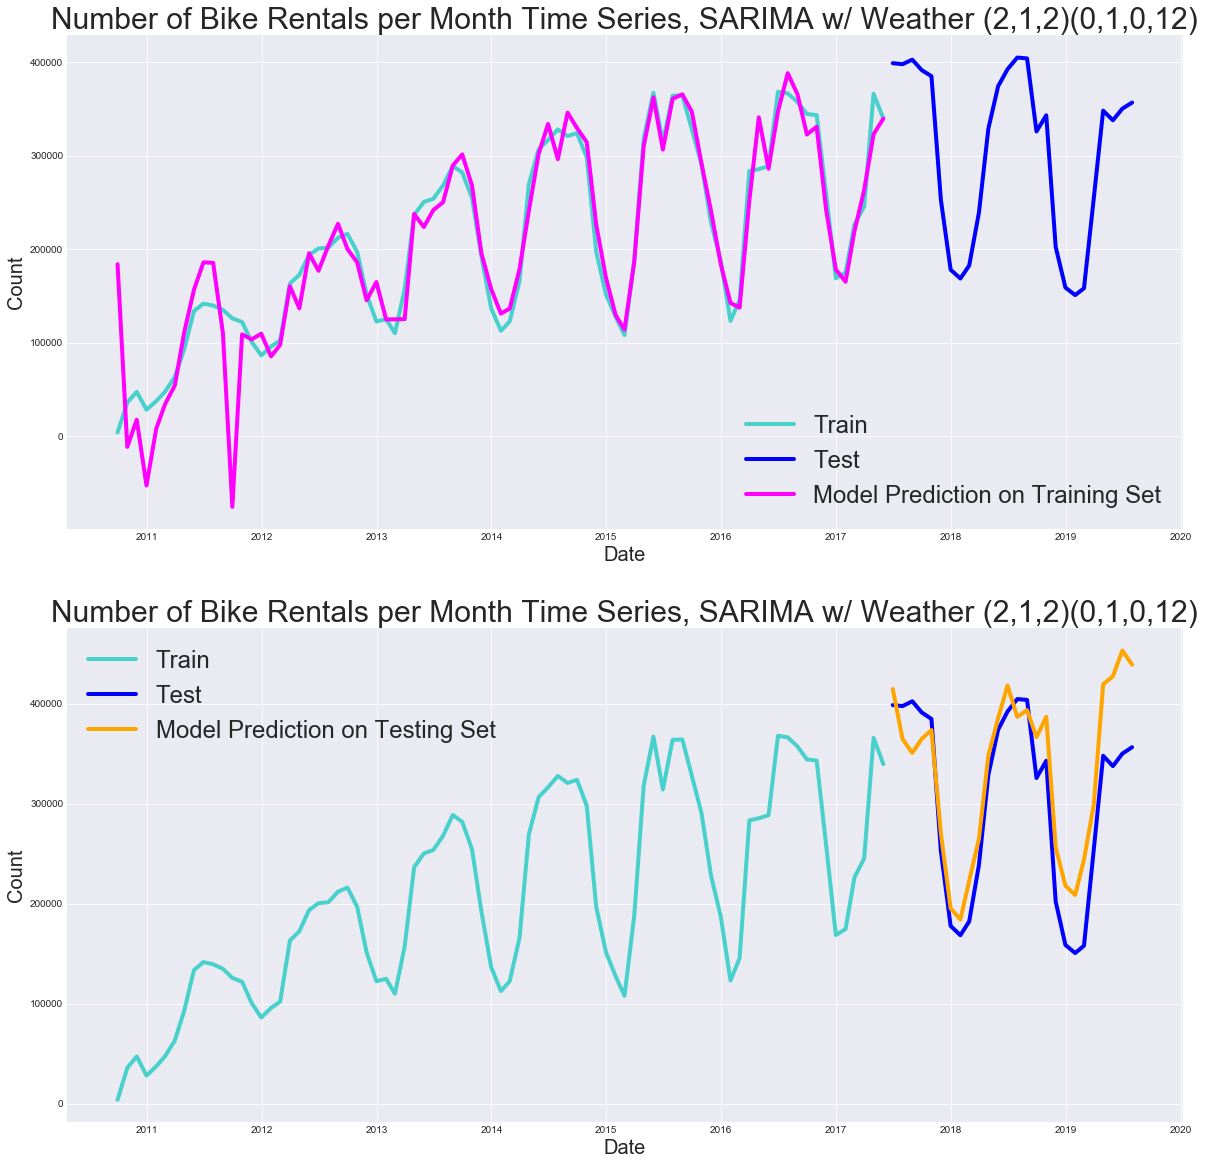

In [317]:
pplot.prediction_plot_exog(model_with_weather_212_01012 , train_m_scaled, test_m_scaled, 2,1,2,0,1,0,12)

## Best Model still appears to be SARIMA (2,1,2)(0,1,1,12) without Weather.

In [320]:
model_212_01112.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              count   No. Observations:                   81
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 12)   Log Likelihood                -802.044
Date:                            Tue, 10 Sep 2019   AIC                           1616.088
Time:                                    11:18:51   BIC                           1629.405
Sample:                                09-30-2010   HQIC                          1621.364
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5021      0.028    -17.645      0.000      -0.558      -0.446
ar.L2         -1.0000      0.041    -24.650      0.000      -1.080      -0.920
ma.L1          0.5938      0.141      4.207      0.000       0.317       0.870
ma.L2          1.0000      0.214      4.668      0.000       0.580       1.420
ma.S.L12      -0.4598      0.134     -3.441      0.001      -0.722      -0.198
sigma2       1.06e+09   2.35e-10   4.52e+18      0.000    1.06e+09    1.06e+09
===================================================================================
Ljung-Box (Q):                       62.06   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.01   Prob(JB):                         0.64
Heteroskedasticity (H):               3.29   Skew:                             0.10
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.14e+34. Standard errors may be unstable.
"""

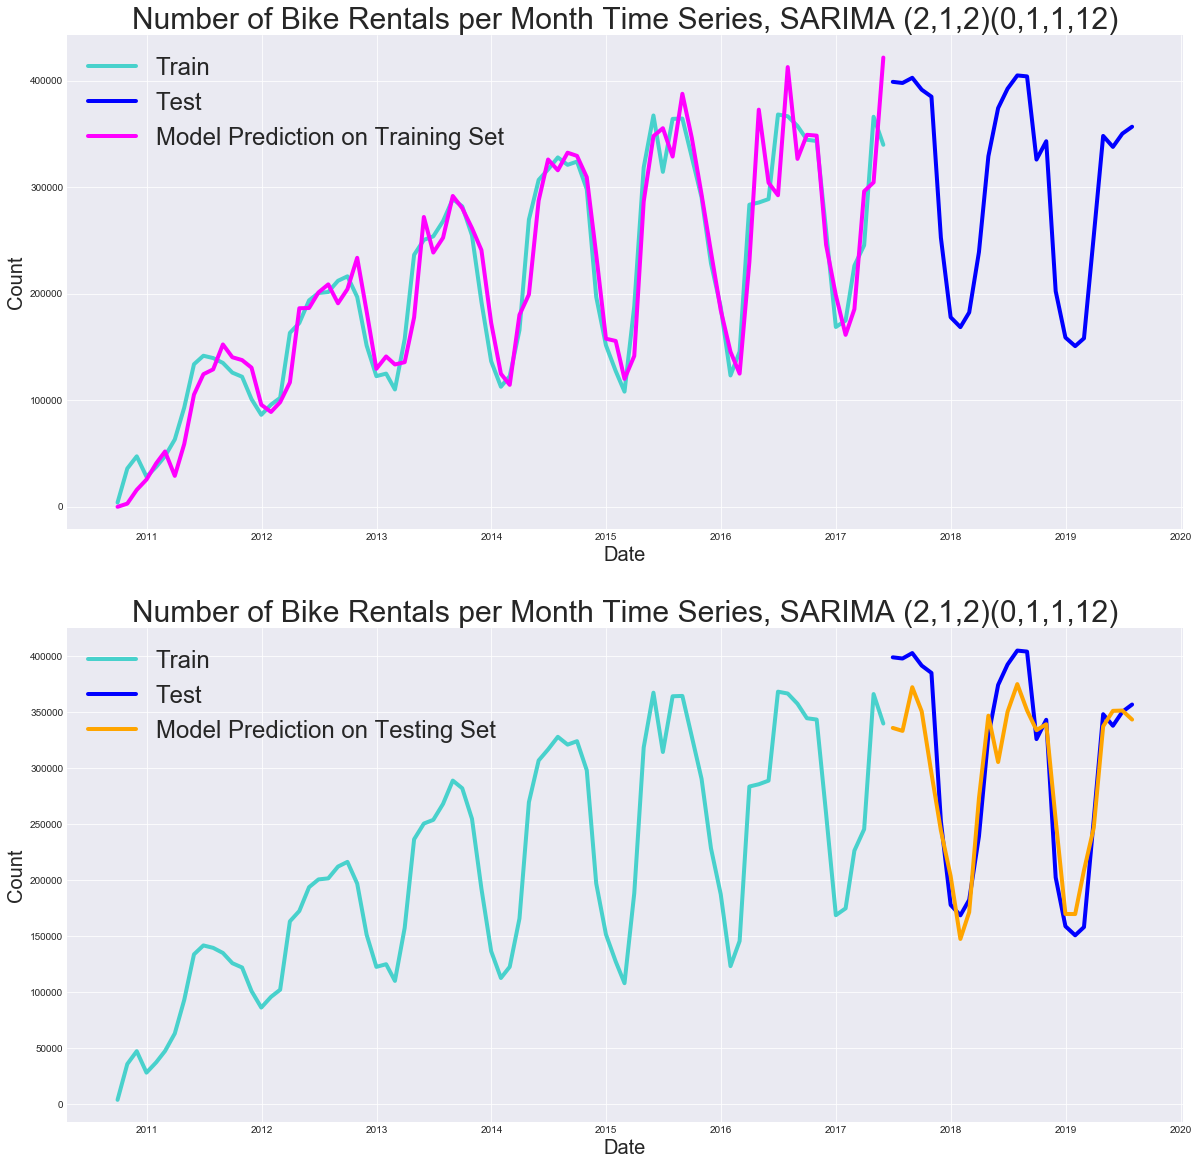

In [333]:
pplot.prediction_plot(model_212_01112,train_m, test_m, 2,1,2,0,1,1,12)

In [357]:
forecast_6_conf_int =  model_212_01112.get_forecast(len(test_m) + 6).conf_int(alpha = .2)

In [358]:
forecast_6_conf_int

lower count    upper count
2017-06-30  293562.200990  377970.591093
2017-07-31  270856.985439  395396.016270
2017-08-31  296395.980666  447792.404487
2017-09-30  264488.672908  436512.997973
2017-10-31  198384.558595  392245.157246
2017-11-30  137454.906007  351149.666162
2017-12-31   89212.066568  318081.342032
2018-01-31   25360.365766  269648.649976
2018-02-28   41011.598858  301921.972071
2018-03-31  135639.670280  410061.542243
2018-04-30  203442.271548  489890.328185
2018-05-31  155160.410175  455472.089550
2018-06-30  185585.387019  514705.740395
2018-07-31  197740.984297  551987.519950
2018-08-31  162165.011012  540543.553258
2018-09-30  132800.553814  534748.770928
2018-10-31  127460.684437  550641.114975
2018-11-30   32117.654298  475210.946439
2018-12-31  -61810.377220  401424.303241
2019-01-31  -71414.160060  410878.109814
2019-02-28  -41128.385713  458613.605017
2019-03-31  -12123.875695  505129.662955
2019-04-30   69863.997639  604571.875082
2019-05-31   75634.275665  626377.002637
2019-06-30   61964.846433  640532.996493
2019-07-31   39529.612428  646906.661613
2019-08-31   63956.074073  697521.736676
2019-09-30   36618.690977  693907.289913
2019-10-31  -32587.059920  649491.349275
2019-11-30 -101074.183618  605350.256967
2019-12-31 -148217.867784  579756.704498
2020-01-31 -211958.735302  537510.968654

In [359]:
forecast_6 = model_212_01112.forecast(len(test_m) + 6)

In [360]:
forecast_6.index

DatetimeIndex(['2017-06-30', '2017-07-31', '2017-08-31', '2017-09-30',
               '2017-10-31', '2017-11-30', '2017-12-31', '2018-01-31',
               '2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31',
               '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30',
               '2018-10-31', '2018-11-30', '2018-12-31', '2019-01-31',
               '2019-02-28', '2019-03-31', '2019-04-30', '2019-05-31',
               '2019-06-30', '2019-07-31', '2019-08-31', '2019-09-30',
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31'],
              dtype='datetime64[ns]', freq='M')

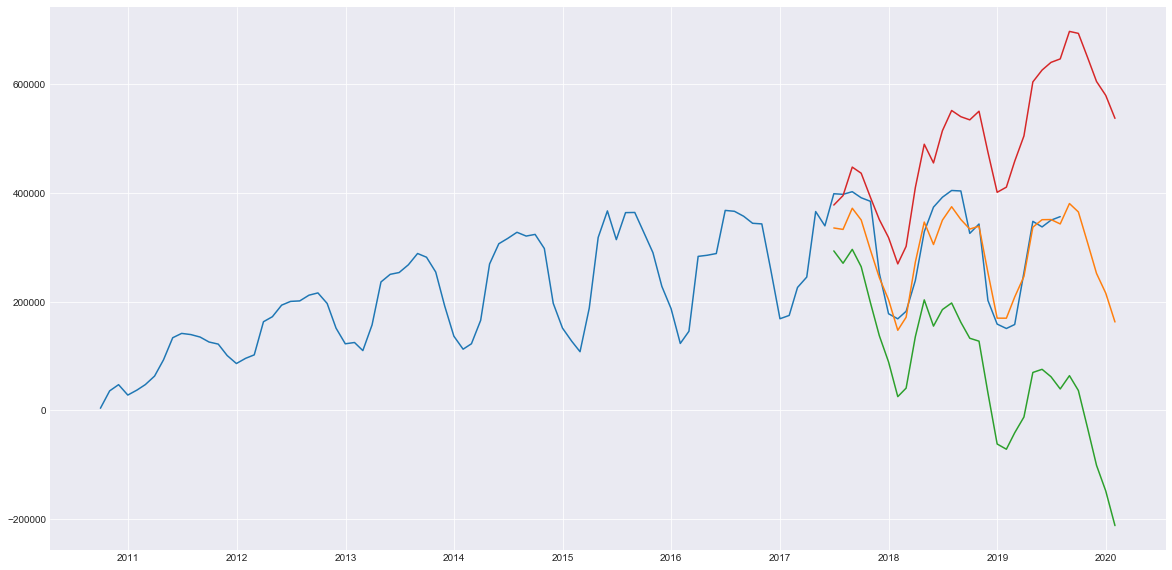

In [361]:
fig = plt.figure(figsize = (20,10))
plt.plot(master_m.index,master_m['count'])
plt.plot(forecast_6.index, forecast_6)
plt.plot(forecast_6_conf_int.index, forecast_6_conf_int['lower count'])
plt.plot(forecast_6_conf_int.index, forecast_6_conf_int['upper count'])